<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230612_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

In [5]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        #self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, 50))
            self.fc2.append(nn.Linear(50, 1))
            #self.fc3.append(nn.Linear(5, 1))

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1)))
            #h1 = F.relu(self.fc2[i](h0))
            #h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = self.fc2[i](h0)
            h2 = self.fc2[i](h0)
            pxy.append(h2)

        return torch.cat(pxy, dim=1)


In [6]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [7]:

def test_model(model_,model2_, tX, ty, s1):
    model_.eval()

    if model2_ == None:
        ax = tX[:,0:5]
    else:
        model2_.eval()
        ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)

    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [8]:
main_figsize=(15,3)

In [9]:

def test_all_data(generator,adapter,train_x, XT,yT, ShowChart = False):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        MISS = {}
        DRF = {}
        for col in columns:
            MISS[col] = []
            DRF[col] = []

        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            tmp_y = yT[bk*bucket_size:bk*bucket_size+bucket_size]
            if adapter == None:
                xs = tmp_x[:,0:5]
            else:
                xs = adapter(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(tmp_y,predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)

            cpu_xs = xs.cpu().data.numpy()
            mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=['x0','x1','x2','x3','z0']), tmp_y, discrete_features="auto")
            ks = __ks_drift(train_x.values,cpu_xs)
            for ix,col in enumerate(columns):
                MISS[col].append(mi_scores[col])
                DRF[col].append(ks[:,0][ix])

        df_mis = pd.DataFrame(MISS)
        df_drf = pd.DataFrame(DRF)

        if ShowChart:
            plt.figure(figsize=main_figsize)
            plt.plot(f1s,linewidth=1)
            plt.ylabel('F1 Score')
            plt.xlabel(f'bucket ({bucket_size})')
            plt.show()

            df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
            plt.legend(loc=1,ncol=5)
            plt.show()

            df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({bucket_size})',fontsize=15)
            plt.legend(loc=1,ncol=5)
            plt.show()

        print(f'mean of drift:\n{df_drf.mean()}')

    print('Mean F1 for all data:',np.mean(f1s))
    return f1s, df_mis, df_drf

In [10]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha, ShowChart = False):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net()
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        else:
            xs = XS_train[:,0:5]
            a_loss = torch.tensor(0)

        a_losses.append(a_loss.cpu().data.numpy())
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss.cpu().data.numpy())

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )

        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({bucket_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

In [11]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [12]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 준비
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

In [ ]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [ ]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

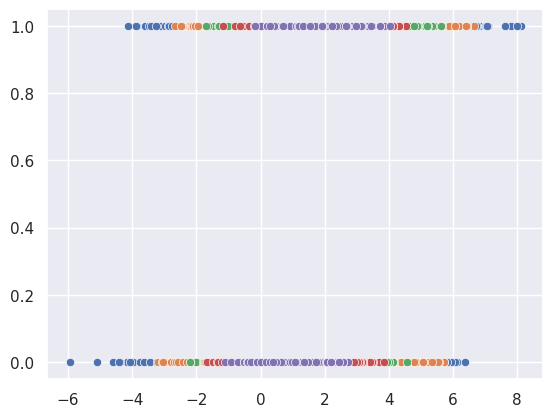

In [ ]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

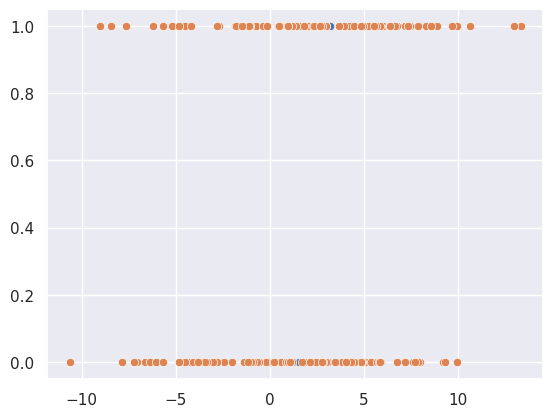

In [ ]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### KS-test 통계량의 측정

In [ ]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 63.92it/s]


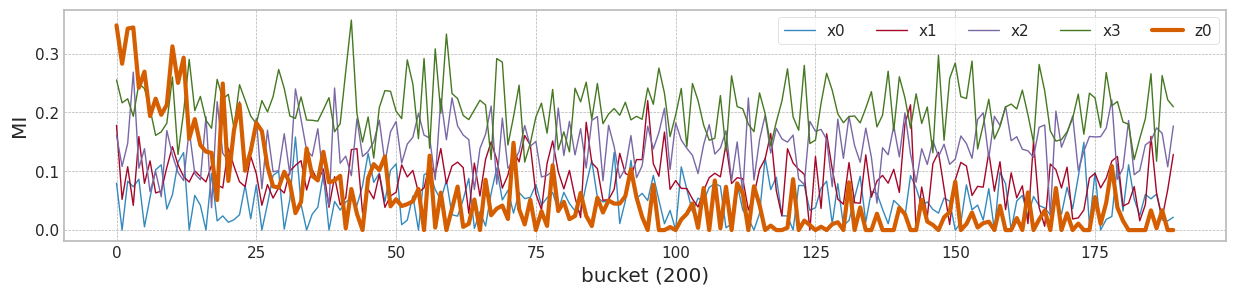

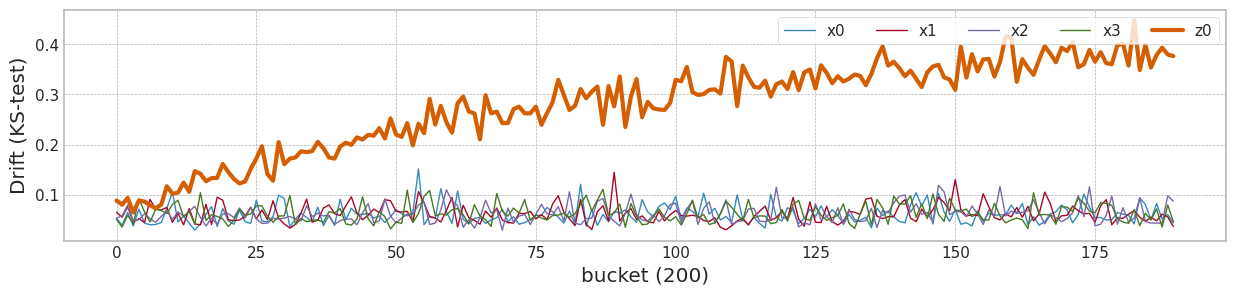

In [ ]:
from tqdm import tqdm

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

### 학습 및 전체 예측

+ 2000개를 학습하고, 이후 38000개를 추정한다.

cuda:0


100%|██████████| 1000/1000 [00:29<00:00, 34.03it/s]


MSE: 0.26
RMSE: 0.51


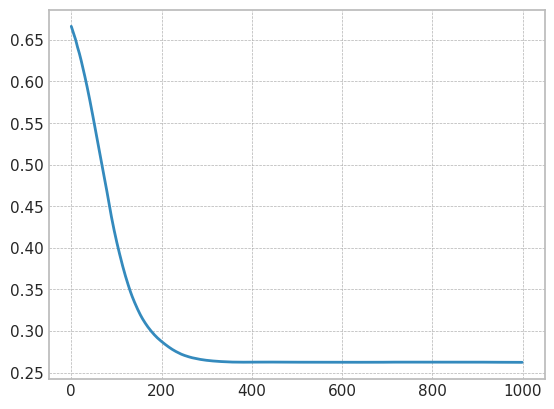

In [ ]:
import copy
import torch.optim as optim

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8685714285714285


100%|██████████| 189/189 [00:00<00:00, 479.91it/s]


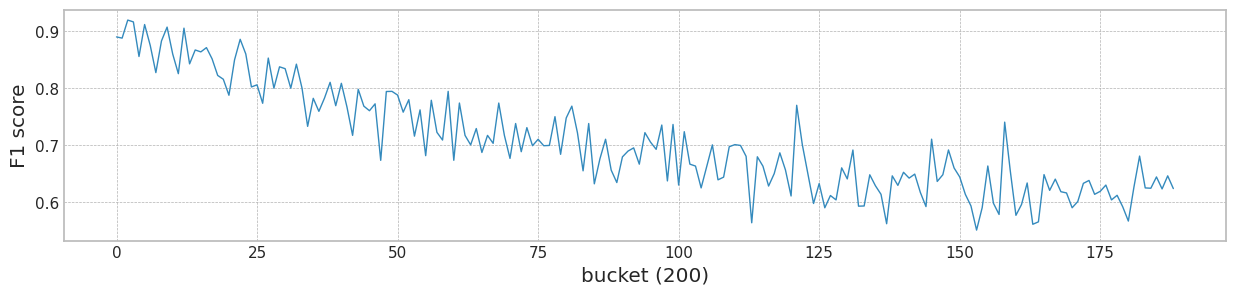

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #1 Feature 5  0.868571  0.889908  0.705877  0.623853       0.0

In [ ]:

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

result_table3['lambda'].append('Case #1 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

### 내성 학습의 적용

In [ ]:

# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

lambda_f2 1.2
cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.663064]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.629238]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.596062]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.559978]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.521746]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.483910]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.442913]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.404920]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.372141]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.343308]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.318049]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.297169]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.280244

100%|██████████| 189/189 [00:03<00:00, 53.62it/s]


mean of drift:
x0    0.061049
x1    0.062651
x2    0.061975
x3    0.063260
z0    0.276490
dtype: float64
Mean F1 for all data: 0.7088965272551265
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 19.316162] [G loss: 0.511208]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 105.180084] [G loss: 0.266944]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 188.331757] [G loss: 0.227124]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 210.090500] [G loss: 0.224848]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 220.921432] [G loss: 0.223697]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 229.876511] [G loss: 0.222694]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 237.072784] [G loss: 0.221774]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 244.026840] [G loss: 0.220871]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 251.326172] [G loss: 0.220045]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 257.993988] [G loss: 0.219292]
[Lambda: 0

100%|██████████| 189/189 [00:03<00:00, 52.21it/s]


mean of drift:
x0    0.999994
x1    0.467075
x2    0.854297
x3    0.995676
z0    0.830808
dtype: float64
Mean F1 for all data: 0.721176812135385
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.020037] [G loss: 0.623222]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.078506] [G loss: 0.569837]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.167775] [G loss: 0.496585]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.265451] [G loss: 0.416552]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.298769] [G loss: 0.355171]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.284817] [G loss: 0.316309]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.253056] [G loss: 0.292837]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.220653] [G loss: 0.277176]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.190217] [G loss: 0.266409]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.167690] [G loss: 0.257279]
[Lambda: 0.100000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 51.99it/s]


mean of drift:
x0    0.551255
x1    0.256379
x2    0.524550
x3    0.315938
z0    0.565006
dtype: float64
Mean F1 for all data: 0.38773448433790614
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.007139] [G loss: 0.627994]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.018357] [G loss: 0.583075]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.039199] [G loss: 0.526471]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.066431] [G loss: 0.461640]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.086831] [G loss: 0.401224]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.093520] [G loss: 0.353786]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.091924] [G loss: 0.320146]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.084111] [G loss: 0.297693]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.075252] [G loss: 0.281987]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.066586] [G loss: 0.270301]
[Lambda: 0.200000] [Epoch 22

100%|██████████| 189/189 [00:03<00:00, 52.08it/s]


mean of drift:
x0    0.171287
x1    0.571105
x2    0.313474
x3    0.440703
z0    0.245938
dtype: float64
Mean F1 for all data: 0.5728063349608085
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.005376] [G loss: 0.629871]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.006886] [G loss: 0.588285]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.014519] [G loss: 0.538230]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.025471] [G loss: 0.480858]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.035334] [G loss: 0.424462]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.041426] [G loss: 0.376283]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.043034] [G loss: 0.339537]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.040916] [G loss: 0.312969]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.037128] [G loss: 0.293951]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.032860] [G loss: 0.279442]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 51.16it/s]


mean of drift:
x0    0.115285
x1    0.438019
x2    0.240750
x3    0.123175
z0    0.261429
dtype: float64
Mean F1 for all data: 0.7850010068760686
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.005101] [G loss: 0.630879]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.003148] [G loss: 0.591079]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.006397] [G loss: 0.544595]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.011234] [G loss: 0.491947]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.016194] [G loss: 0.438926]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.019932] [G loss: 0.391833]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.021470] [G loss: 0.354412]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.021262] [G loss: 0.325588]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.019570] [G loss: 0.304038]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.017511] [G loss: 0.287310]
[Lambda: 0.400000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 50.78it/s]


mean of drift:
x0    0.118119
x1    0.151725
x2    0.175441
x3    0.488292
z0    0.524888
dtype: float64
Mean F1 for all data: 0.7659473098764698
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.005159] [G loss: 0.631501]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.001599] [G loss: 0.592844]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.003039] [G loss: 0.548592]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.005177] [G loss: 0.499179]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.007710] [G loss: 0.448796]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.009757] [G loss: 0.403218]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.010920] [G loss: 0.365708]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.010945] [G loss: 0.336137]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.010325] [G loss: 0.312799]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.009238] [G loss: 0.294069]
[Lambda: 0.500000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 52.07it/s]


mean of drift:
x0    0.092269
x1    0.107687
x2    0.107266
x3    0.162663
z0    0.245082
dtype: float64
Mean F1 for all data: 0.8244244113177561
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.005296] [G loss: 0.631926]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.000920] [G loss: 0.594047]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.001478] [G loss: 0.551396]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.002448] [G loss: 0.504040]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.003603] [G loss: 0.455949]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.004680] [G loss: 0.411699]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.005354] [G loss: 0.374579]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.005465] [G loss: 0.344564]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.005190] [G loss: 0.320457]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.004633] [G loss: 0.300408]
[Lambda: 0.600000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 52.05it/s]


mean of drift:
x0    0.067493
x1    0.084621
x2    0.099165
x3    0.095288
z0    0.184744
dtype: float64
Mean F1 for all data: 0.8060833514922492
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.005442] [G loss: 0.632233]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.000630] [G loss: 0.594915]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.000662] [G loss: 0.553504]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.001035] [G loss: 0.507932]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.001551] [G loss: 0.461480]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.002032] [G loss: 0.418524]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.002417] [G loss: 0.381711]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.002499] [G loss: 0.351338]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.002388] [G loss: 0.326485]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.002161] [G loss: 0.305532]
[Lambda: 0.700000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 51.30it/s]


mean of drift:
x0    0.062892
x1    0.074521
x2    0.079133
x3    0.074018
z0    0.240808
dtype: float64
Mean F1 for all data: 0.730102436404008
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.005581] [G loss: 0.632467]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.000497] [G loss: 0.595641]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000316] [G loss: 0.555041]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000401] [G loss: 0.510713]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.000560] [G loss: 0.465739]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.000725] [G loss: 0.424046]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.000863] [G loss: 0.387982]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.000912] [G loss: 0.357326]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.000899] [G loss: 0.331731]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.000830] [G loss: 0.309941]
[Lambda: 0.800000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 51.42it/s]


mean of drift:
x0    0.061931
x1    0.071449
x2    0.073474
x3    0.079997
z0    0.255838
dtype: float64
Mean F1 for all data: 0.7209201312161698
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 4.777493] [G loss: 0.691752]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.005705] [G loss: 0.632652]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.000453] [G loss: 0.596164]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000182] [G loss: 0.556232]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000127] [G loss: 0.512988]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000144] [G loss: 0.469201]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000171] [G loss: 0.428535]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000195] [G loss: 0.393073]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000204] [G loss: 0.362482]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000197] [G loss: 0.336422]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000184] [G loss: 0.314011]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 50.28it/s]


mean of drift:
x0    0.062281
x1    0.065967
x2    0.069280
x3    0.076690
z0    0.266705
dtype: float64
Mean F1 for all data: 0.714946437788246


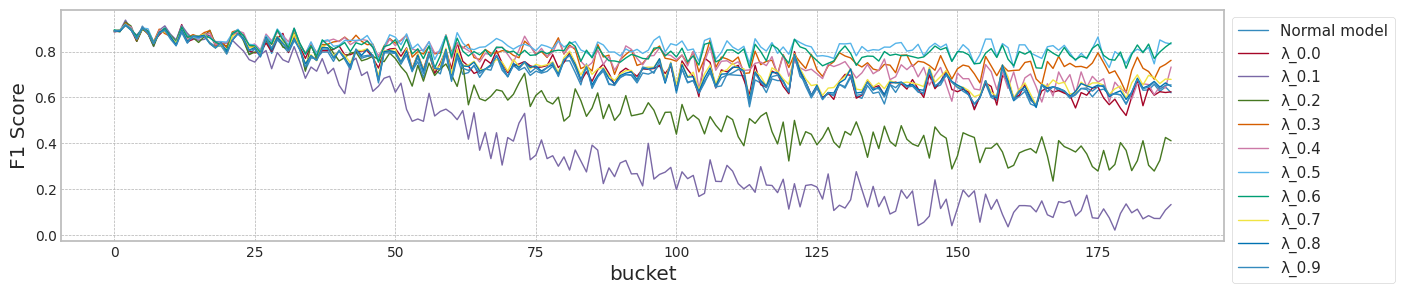

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #1, Normal model  0.881356  0.884793  0.708897  0.620370  0.259820
1                     0.0  0.898876  0.889908  0.721177  0.624390  0.265435
2                     0.1  0.870056  0.889908  0.387734  0.133333  0.229369
3                     0.2  0.858757  0.890909  0.572806  0.410959  0.228114
4                     0.3  0.865169  0.886878  0.785001  0.761905  0.250609
5                     0.4  0.870056  0.885845  0.765947  0.732673  0.266231
6                     0.5  0.875000  0.889908  0.824424  0.833333  0.261667
7                     0.6  0.881356  0.894977  0.806083  0.837945  0.259820
8                     0.7  0.875000  0.889908  0.730102  0.678733  0.261667
9                     0.8  0.875000  0.889908  0.720920  0.648402  0.261667
10                    0.9  0.875000  0.889908  0.714946  0.654545  0.261667
max_mean_lambda= 0.5


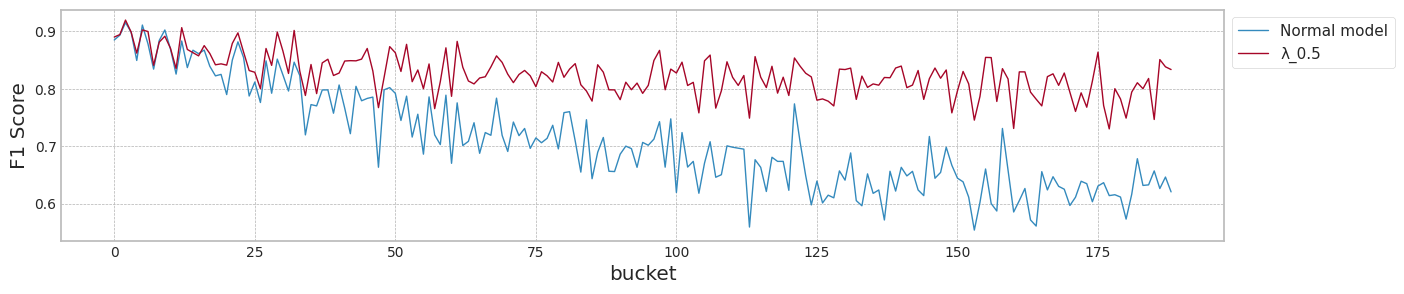

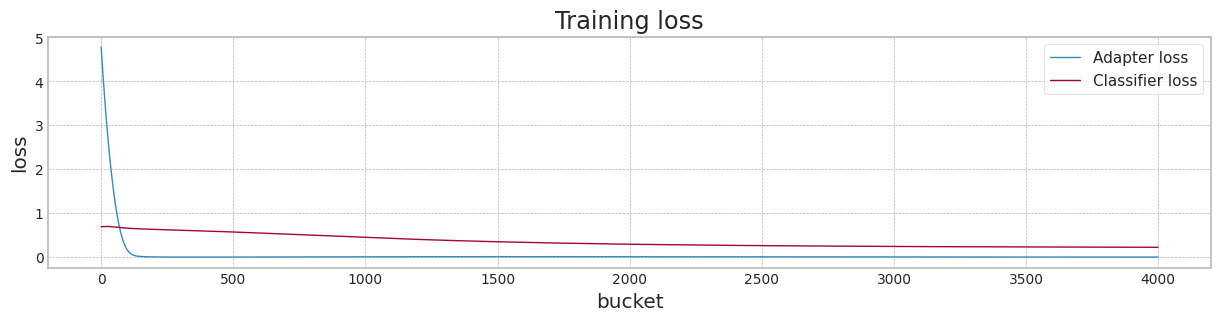

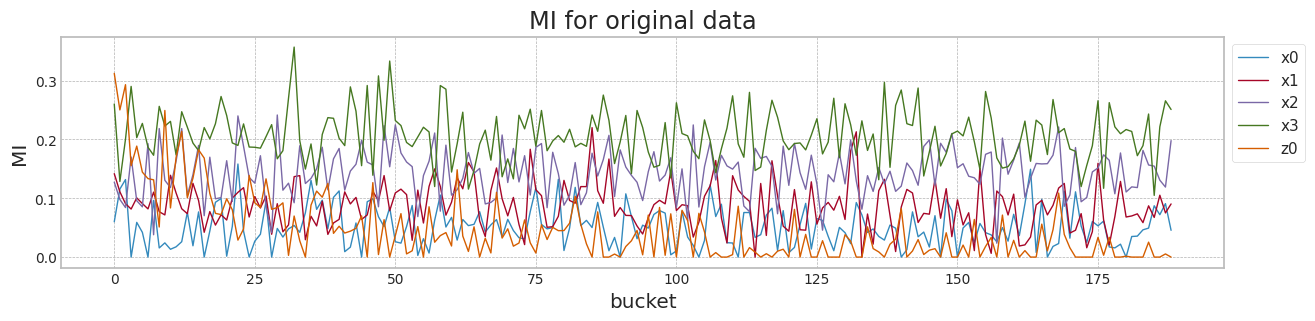

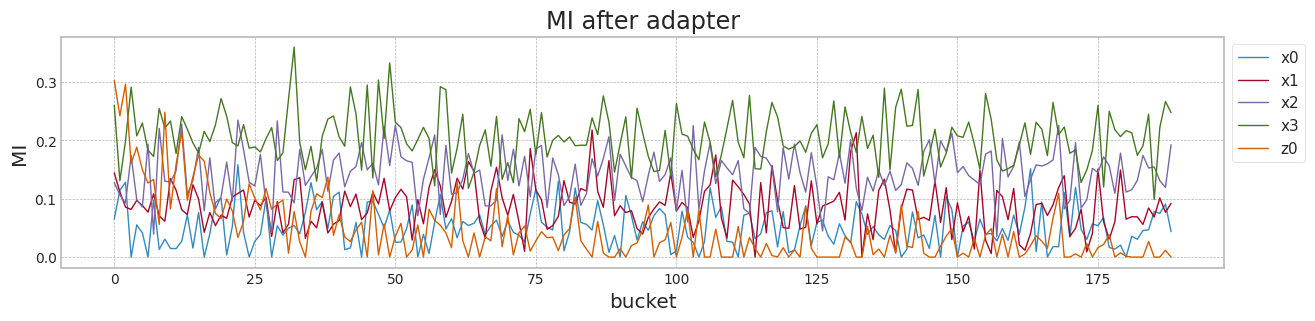

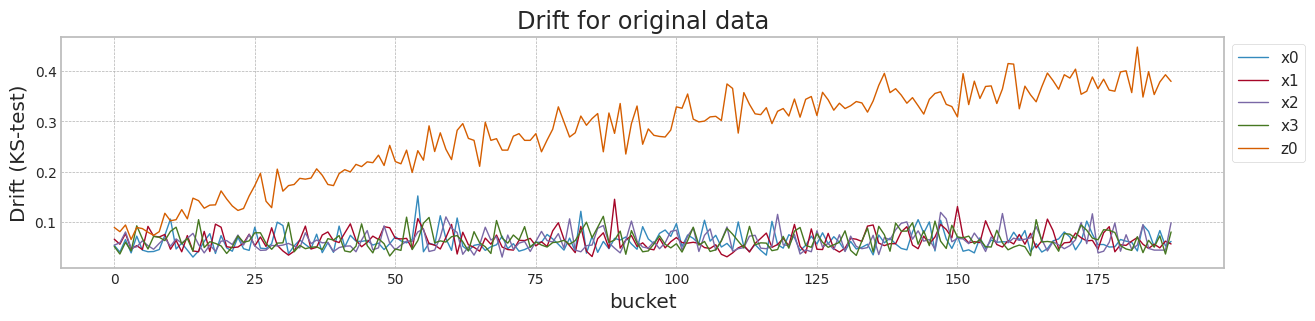

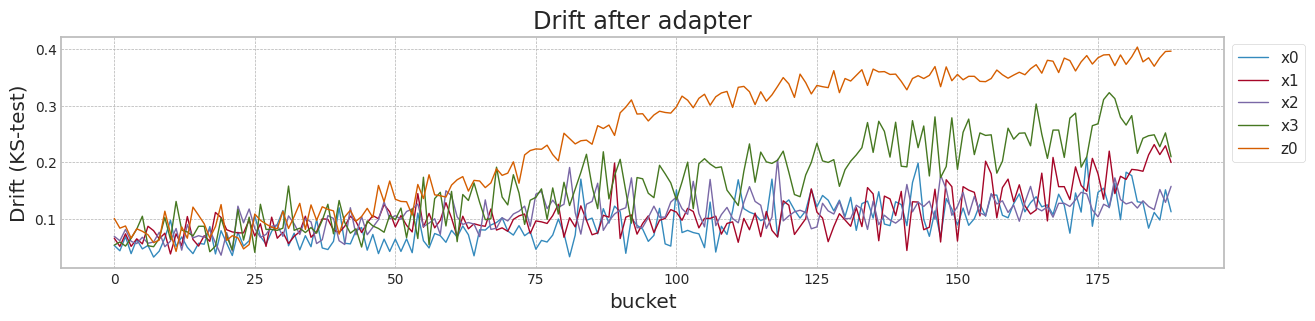

In [ ]:
avaible_range = 400
seed = 1
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
lambda_f_set2 = [1.2]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2
    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X[0:1800][['x0','x1','x2','x3','z0']],X[2000:][['x0','x1','x2','x3','z0','b']],y[2000:])
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()


## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

In [ ]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [ ]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [ ]:
x1.shape

(40000, 5)

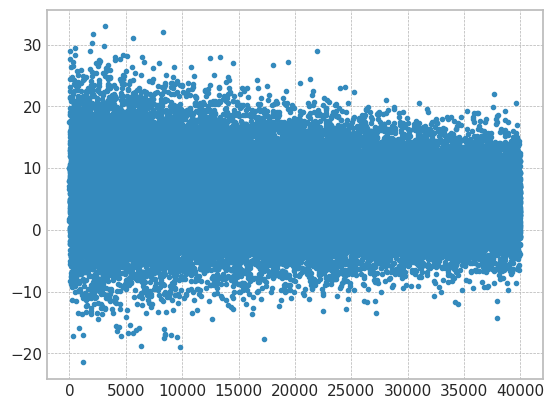

In [ ]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

plt.plot(y1_array,'.')

In [ ]:
y1 = [1 if y_ > 5 else 0 for y_ in y1_array]

In [ ]:
sum(y1)

21325

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

x0    0.227465
z0    0.088169
x1    0.018550
x3    0.008429
x2    0.006772
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 65.12it/s]


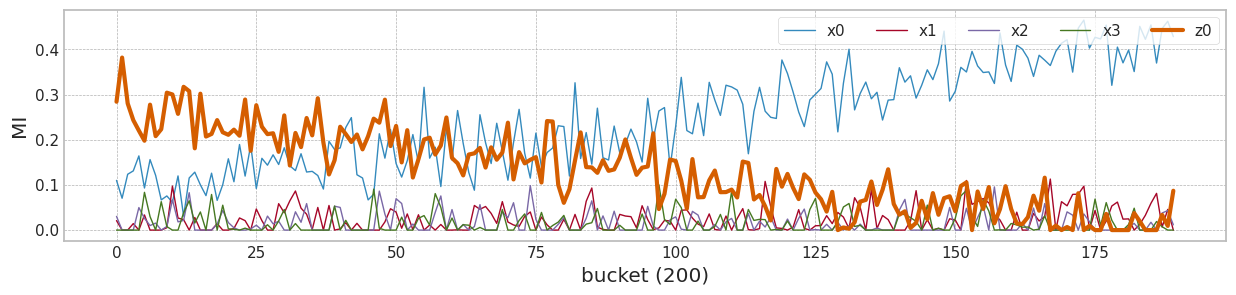

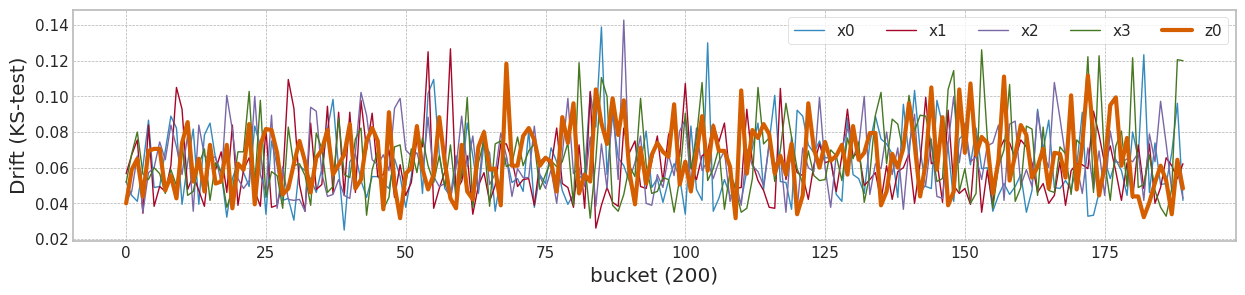

In [ ]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X1[bk*bucket_size:bk*bucket_size+bucket_size], y1[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X1[0:1800].values,X1[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

### 학습 및 전체 예측

cuda:0


100%|██████████| 1000/1000 [00:27<00:00, 36.58it/s]


MSE: 0.04
RMSE: 0.19


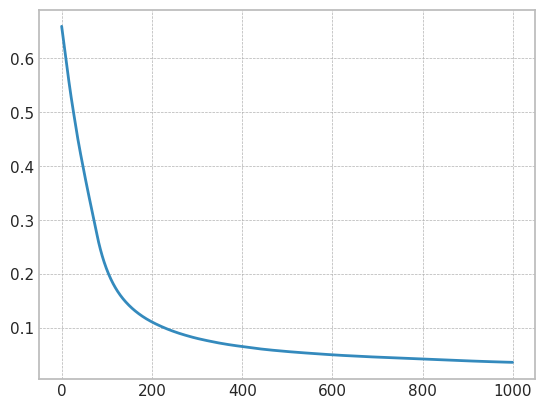

In [ ]:
import copy
import torch.optim as optim

seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y1[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y1[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

100%|██████████| 189/189 [00:00<00:00, 460.00it/s]


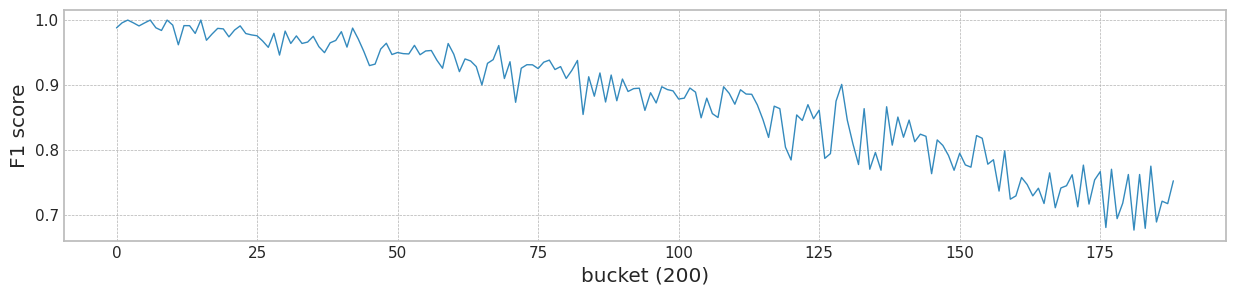

lambda  test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #2 Feature 5    0.875  0.987952  0.877103  0.752137  0.087066

In [ ]:
XT = X1[2000:][['x0','x1','x2','x3','z0']]
yT = y1[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

result_table3['lambda'].append('Case #2 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

In [ ]:
X1['b'] = [int(b) for b in X1.index.values]
X1

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792 -1.925585      0
1      2.846794  0.461018  1.213784  1.282154  3.281450      1
2      2.232850  0.876278  2.307393  2.019052  0.187403      2
3     -0.198843  2.579531  0.078102  1.019118  2.385340      3
4      1.618080  1.683218  1.826908  0.697273  0.195648      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070  4.096949  39995
39996 -0.037401  1.055617  0.084065  1.252068  3.850920  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.498200  39997
39998  0.823467  1.489013 -0.191516 -0.238143  5.022454  39998
39999  2.024101  2.498025  0.198514  2.241146  0.816579  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.670989]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.601290]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.527616]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.460968]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.401566]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.338360]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.282020]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.238982]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.206156]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.180878]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.161100]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.145068]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.131681]
[Lambda: -0.

100%|██████████| 189/189 [00:03<00:00, 49.87it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.065844
dtype: float64
Mean F1 for all data: 0.8676675451930798
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 44.337929] [G loss: 0.479356]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 258.603058] [G loss: 0.167605]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 517.607544] [G loss: 0.078098]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 741.547424] [G loss: 0.051432]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 960.810425] [G loss: 0.037684]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 1181.940186] [G loss: 0.029118]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 1411.487183] [G loss: 0.022937]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 1654.074341] [G loss: 0.018343]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 1889.434204] [G loss: 0.015104]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 2127.275635] [G loss: 0.012432]
[Lamb

100%|██████████| 189/189 [00:03<00:00, 51.05it/s]


mean of drift:
x0    0.514368
x1    0.625579
x2    0.981046
x3    1.000000
z0    0.524045
dtype: float64
Mean F1 for all data: 0.9129560221808936
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.065951] [G loss: 0.575243]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.078144] [G loss: 0.493714]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.099995] [G loss: 0.420184]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.136796] [G loss: 0.340409]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.146494] [G loss: 0.270942]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.138476] [G loss: 0.221807]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.127138] [G loss: 0.185755]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.116526] [G loss: 0.158431]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.107120] [G loss: 0.137230]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.099970] [G loss: 0.120165]
[Lambda: 0.100000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 50.91it/s]


mean of drift:
x0    0.423574
x1    0.220714
x2    0.598610
x3    0.568613
z0    0.260894
dtype: float64
Mean F1 for all data: 0.7833643820519409
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.018489] [G loss: 0.584703]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.019629] [G loss: 0.504157]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.022988] [G loss: 0.436378]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.033968] [G loss: 0.364682]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.040136] [G loss: 0.293834]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.040487] [G loss: 0.240804]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.038645] [G loss: 0.201636]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.036420] [G loss: 0.172037]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.034431] [G loss: 0.149101]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.032889] [G loss: 0.130767]
[Lambda: 0.200000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 50.85it/s]


mean of drift:
x0    0.364312
x1    0.116805
x2    0.578122
x3    0.335165
z0    0.172002
dtype: float64
Mean F1 for all data: 0.8695814142813798
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.010342] [G loss: 0.588097]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.007837] [G loss: 0.508489]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.008714] [G loss: 0.442148]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.012524] [G loss: 0.375815]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.015766] [G loss: 0.306562]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.016355] [G loss: 0.251562]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.016089] [G loss: 0.210864]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.015498] [G loss: 0.180158]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.015158] [G loss: 0.156224]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.014811] [G loss: 0.137167]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 50.36it/s]


mean of drift:
x0    0.292119
x1    0.077166
x2    0.470509
x3    0.145500
z0    0.123460
dtype: float64
Mean F1 for all data: 0.9156953502345548
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.007799] [G loss: 0.589868]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.003998] [G loss: 0.510795]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.004074] [G loss: 0.445162]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.005486] [G loss: 0.382395]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.007194] [G loss: 0.315968]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.007550] [G loss: 0.259067]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.007546] [G loss: 0.217348]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.007504] [G loss: 0.185821]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.007392] [G loss: 0.161405]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.007369] [G loss: 0.141970]
[Lambda: 0.400000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 49.35it/s]


mean of drift:
x0    0.216514
x1    0.099597
x2    0.402066
x3    0.089935
z0    0.112384
dtype: float64
Mean F1 for all data: 0.924911304364104
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.006791] [G loss: 0.590945]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.002412] [G loss: 0.512229]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.002156] [G loss: 0.447056]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.002640] [G loss: 0.386431]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.003465] [G loss: 0.323261]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.003699] [G loss: 0.264581]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.003740] [G loss: 0.221905]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.003696] [G loss: 0.189941]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.003674] [G loss: 0.165207]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.003734] [G loss: 0.145577]
[Lambda: 0.500000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 50.77it/s]


mean of drift:
x0    0.134206
x1    0.095770
x2    0.252028
x3    0.076473
z0    0.095797
dtype: float64
Mean F1 for all data: 0.9114407924489931
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.006339] [G loss: 0.591663]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.001672] [G loss: 0.513202]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.001261] [G loss: 0.448361]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.001353] [G loss: 0.388887]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.001693] [G loss: 0.328799]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.001831] [G loss: 0.269610]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.001838] [G loss: 0.225904]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.001815] [G loss: 0.193371]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.001827] [G loss: 0.168297]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.001864] [G loss: 0.148571]
[Lambda: 0.600000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 51.13it/s]


mean of drift:
x0    0.089286
x1    0.094071
x2    0.121755
x3    0.075844
z0    0.084168
dtype: float64
Mean F1 for all data: 0.900023537259777
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.006126] [G loss: 0.592189]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.001305] [G loss: 0.513911]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.000822] [G loss: 0.449310]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.000745] [G loss: 0.390311]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.000821] [G loss: 0.332271]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.000864] [G loss: 0.273652]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.000854] [G loss: 0.228932]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.000837] [G loss: 0.195970]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.000845] [G loss: 0.170716]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.000878] [G loss: 0.150909]
[Lambda: 0.700000] [Epoch 2200

100%|██████████| 189/189 [00:03<00:00, 50.74it/s]


mean of drift:
x0    0.073918
x1    0.082684
x2    0.081690
x3    0.075773
z0    0.075270
dtype: float64
Mean F1 for all data: 0.89094844102321
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.006028] [G loss: 0.592582]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.001120] [G loss: 0.514450]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000607] [G loss: 0.450032]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000449] [G loss: 0.391394]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.000406] [G loss: 0.334911]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.000388] [G loss: 0.277870]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.000364] [G loss: 0.231717]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.000349] [G loss: 0.198266]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.000350] [G loss: 0.172791]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.000358] [G loss: 0.152966]
[Lambda: 0.800000] [Epoch 2200/

100%|██████████| 189/189 [00:03<00:00, 48.56it/s]


mean of drift:
x0    0.068304
x1    0.071822
x2    0.070988
x3    0.073801
z0    0.068771
dtype: float64
Mean F1 for all data: 0.8855025678733823
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 4.252340] [G loss: 0.704358]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.005988] [G loss: 0.592887]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.001032] [G loss: 0.514873]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000507] [G loss: 0.450607]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000317] [G loss: 0.392248]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000227] [G loss: 0.337018]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000180] [G loss: 0.282182]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000150] [G loss: 0.234360]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000133] [G loss: 0.200385]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000124] [G loss: 0.174716]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000119] [G loss: 0.154858]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 49.70it/s]


mean of drift:
x0    0.064056
x1    0.064006
x2    0.067472
x3    0.073489
z0    0.065641
dtype: float64
Mean F1 for all data: 0.878191295430785


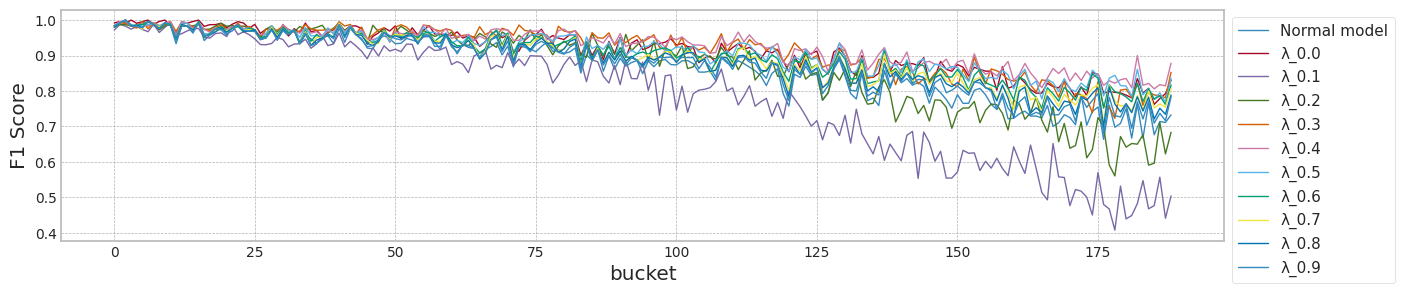

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #1, Normal model  0.969697  0.984000  0.867668  0.732759  0.280002
1                     0.0  0.986667  0.991935  0.912956  0.830357  0.296459
2                     0.1  0.969957  0.972112  0.783364  0.503597  0.307413
3                     0.2  0.973913  0.980080  0.869581  0.683230  0.292253
4                     0.3  0.973913  0.984000  0.915695  0.852632  0.292253
5                     0.4  0.978166  0.984000  0.924911  0.878505  0.304856
6                     0.5  0.973913  0.984000  0.911441  0.835443  0.293090
7                     0.6  0.969697  0.980080  0.900024  0.816667  0.280002
8                     0.7  0.969697  0.980080  0.890948  0.806584  0.280002
9                     0.8  0.969697  0.980080  0.885503  0.788382  0.280002
10                    0.9  0.969697  0.984000  0.878191  0.783333  0.280002
max_mean_lambda= 0.4


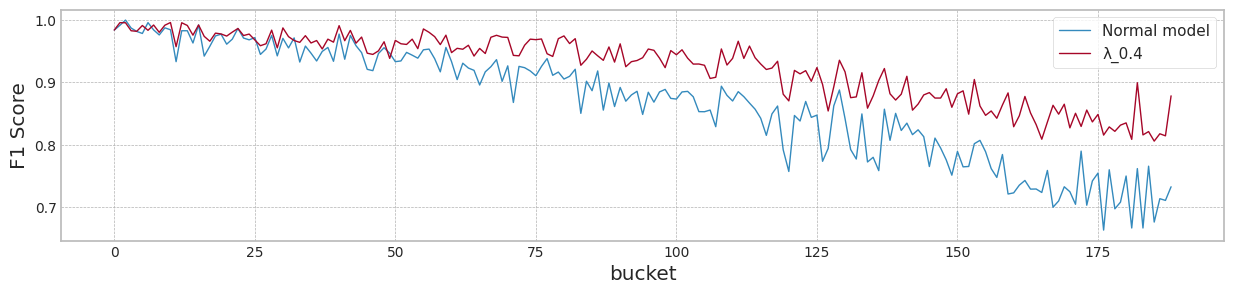

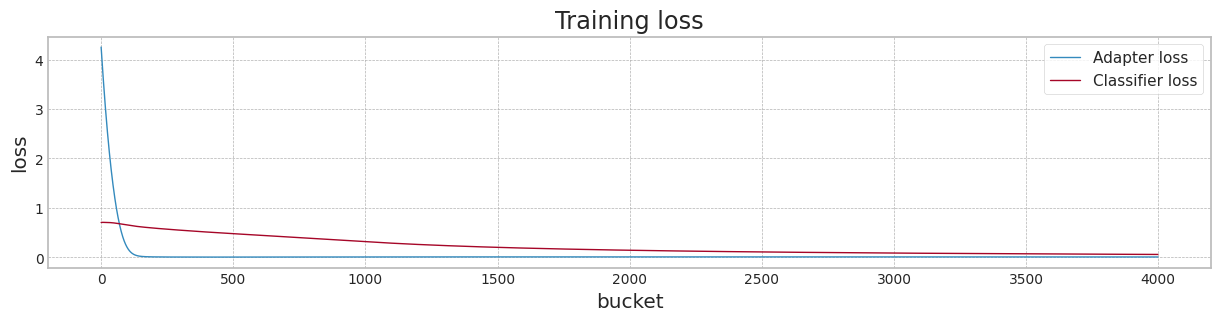

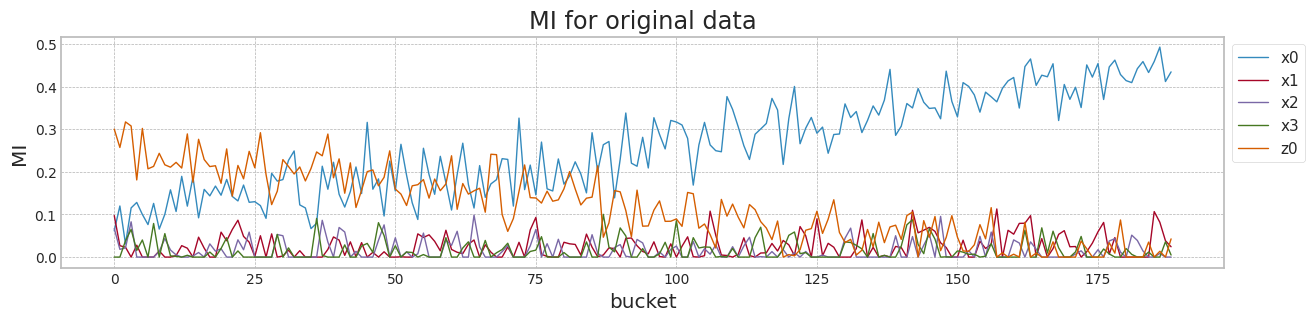

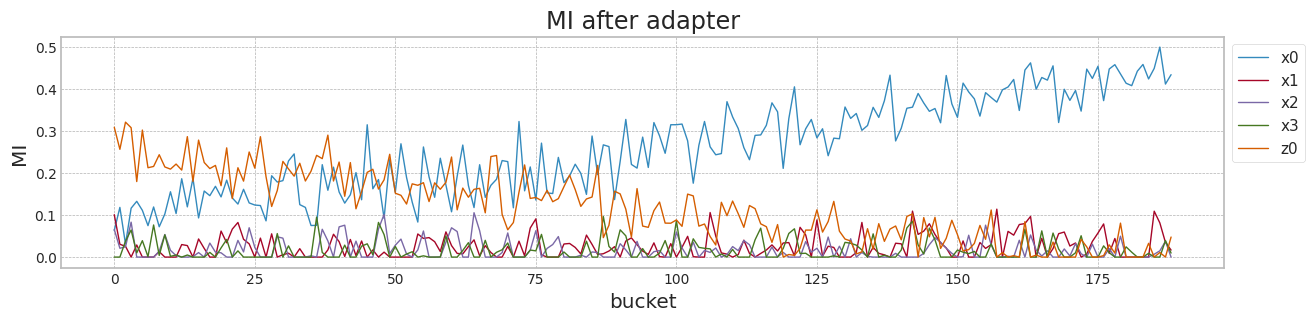

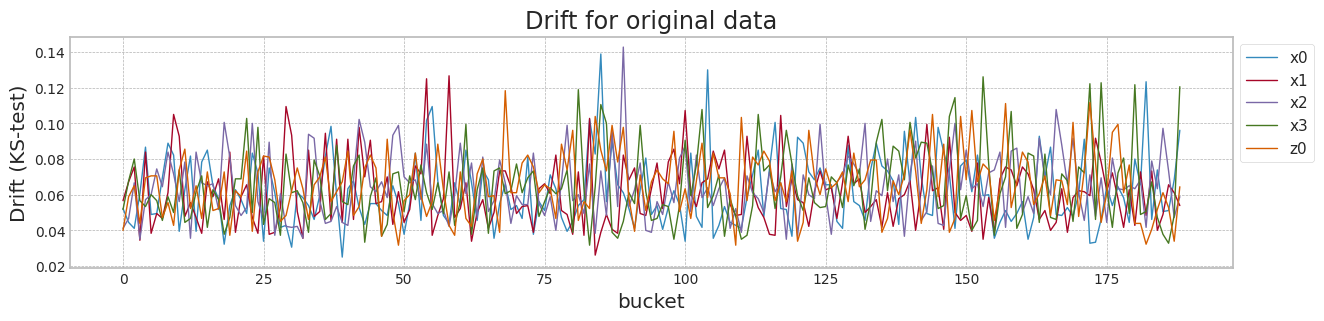

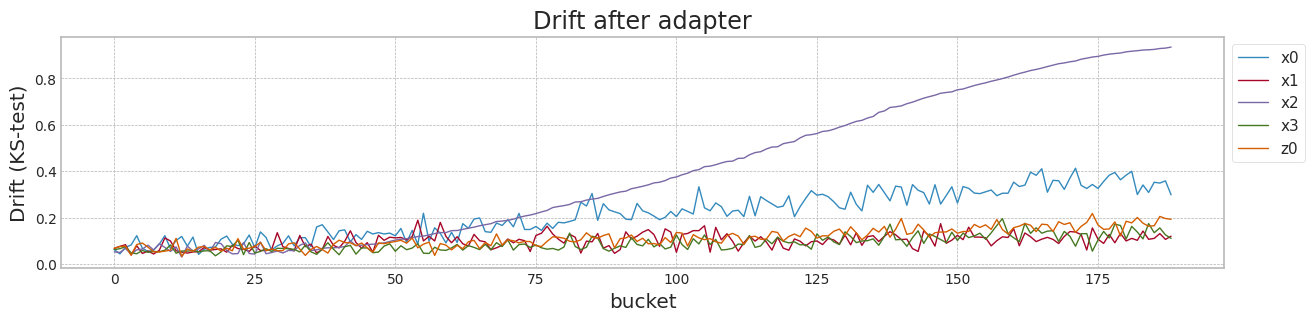

In [ ]:
seed_everything()

train_result = []

avaible_range = 40000

train_tensors = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [-0.1, 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091]
lambda_f_set2 = [1.2]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf  = test_all_data(last_generator,last_adapter,X1[0:1800][['x0','x1','x2','x3','z0']],X1[2000:][['x0','x1','x2','x3','z0','b']],y1[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## synthetic data의 생성 (Case #3 MI의 고정, Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

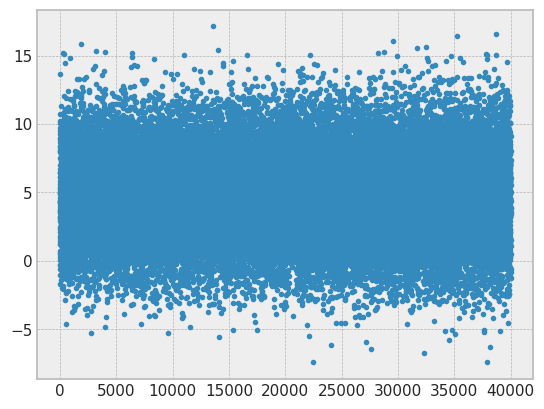

In [13]:
import matplotlib.pyplot as plt

seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii]))

plt.plot(y2_array,'.')

In [14]:
y2 = [1 if y_ > 5 else 0 for y_ in y2_array]

In [15]:
sum(y2)

18970

In [16]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

x0    0.227988
x1    0.076780
z0    0.024660
x2    0.019831
x3    0.013307
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 200/200 [00:03<00:00, 52.30it/s]


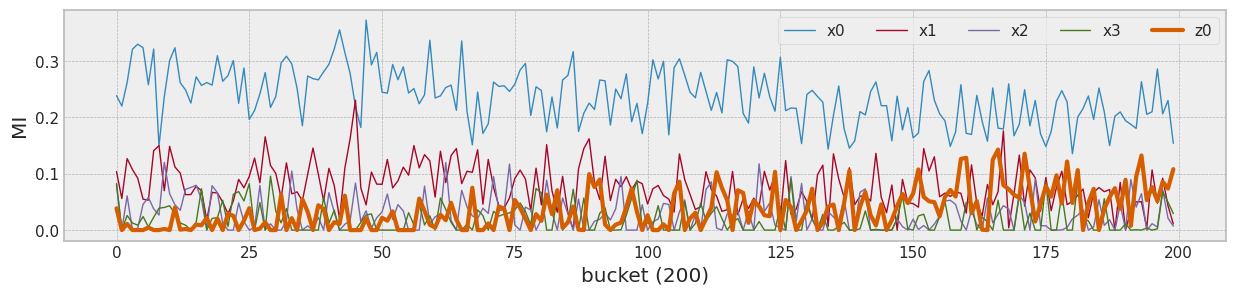

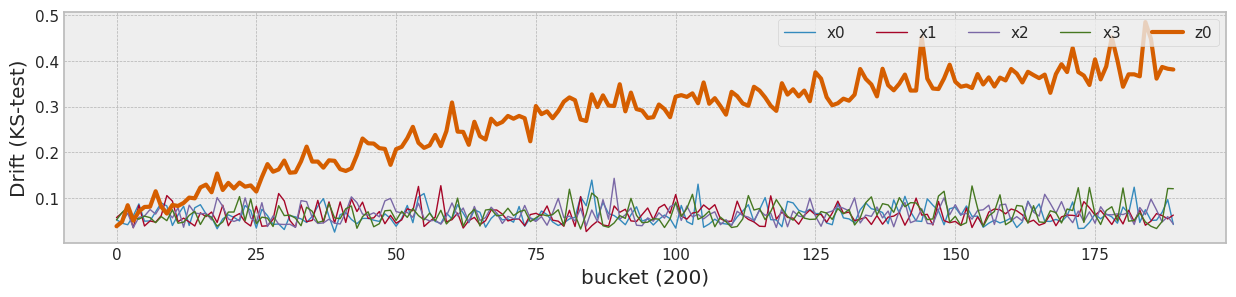

In [17]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((X2.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2[bk*bucket_size:bk*bucket_size+bucket_size], y2[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X2[0:1800].values,X2[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

### 학습 및 전체 예측

#### Case #3의 feature 5

cuda:0


100%|██████████| 1000/1000 [00:27<00:00, 35.73it/s]


MSE: 0.03
RMSE: 0.18


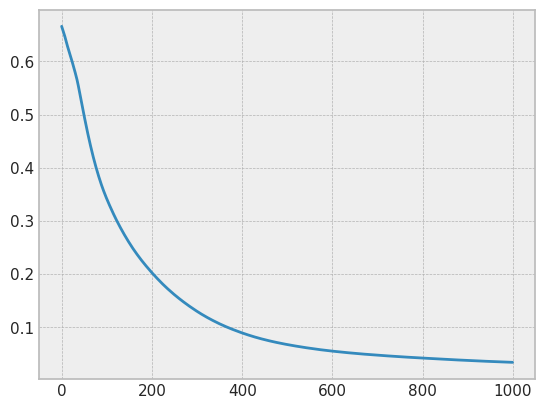

feature 5, test_f1 0.9868421052631579


In [18]:
import copy
import torch.optim as optim

seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

100%|██████████| 189/189 [00:00<00:00, 535.62it/s]


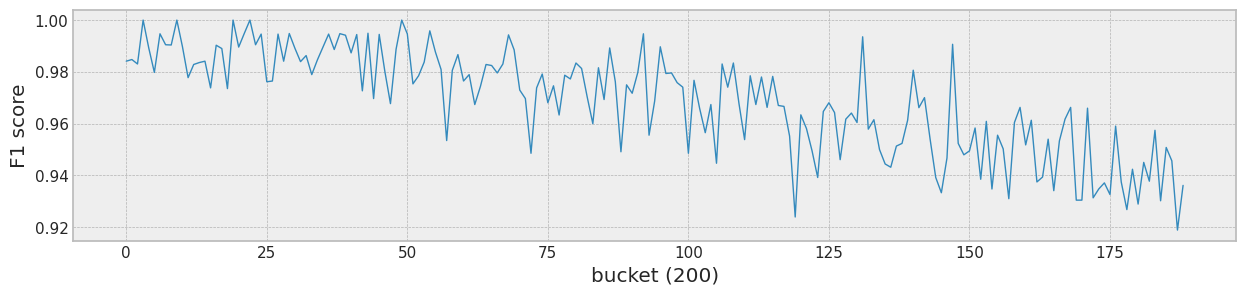

lambda   test_f1   init_f1   mean_f1  last_f1  MI(y^,z)
0  Case #3 Feature 5  0.986842  0.984127  0.968748  0.93617  0.108215

In [19]:
XT = X2[2000:][['x0','x1','x2','x3','z0']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

result_table3['lambda'].append('Case #3 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

#### Case #3의 feature 4

cuda:0


100%|██████████| 1000/1000 [00:22<00:00, 43.64it/s]


MSE: 0.08
RMSE: 0.28


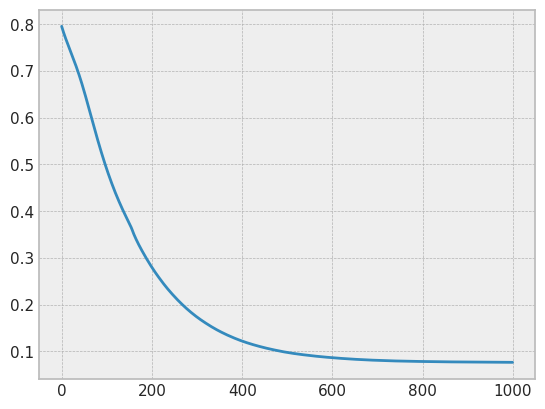

feature 4, test_f1 0.954248366013072


In [20]:
import copy
import torch.optim as optim

seed_everything()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 4, test_f1',f1)

100%|██████████| 189/189 [00:00<00:00, 498.36it/s]


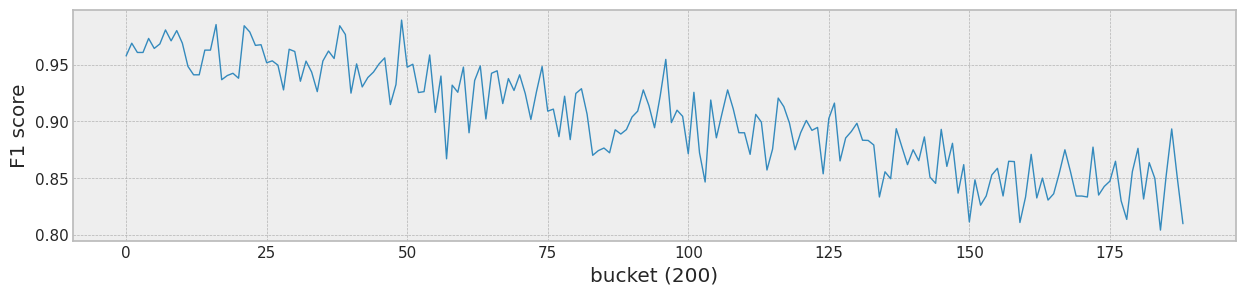

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #3 Feature 5  0.986842  0.984127  0.968748  0.936170  0.108215
1  Case #3 Feature 4  0.954248  0.957895  0.902933  0.809756  0.108215

In [21]:
XT = X2[2000:][['x0','x1','x2','x3']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()
'''
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]
'''
result_table3['lambda'].append('Case #3 Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

In [22]:
X2['b'] = [int(b) for b in X2.index.values]
X2

x0        x1        x2        x3        z0      b
0      1.877314  1.185467 -0.002710  1.124792  0.414883      0
1      2.846794  0.461018  1.213784  1.282154  1.456334      1
2      2.232850  0.876278  2.307393  2.019052  0.837239      2
3     -0.198843  2.579531  0.078102  1.019118  1.277169      3
4      1.618080  1.683218  1.826908  0.697273  0.839361      4
...         ...       ...       ...       ...       ...    ...
39995 -0.321489  0.268097 -0.178799  1.410070 -2.562643  39995
39996 -0.037401  1.055617  0.084065  1.252068 -2.160164  39996
39997  2.262545 -0.256564  1.445491  1.256208  0.476012  39997
39998  0.823467  1.489013 -0.191516 -0.238143  2.303669  39998
39999  2.024101  2.498025  0.198514  2.241146  0.462217  39999

[40000 rows x 6 columns]

cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.679306]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.637307]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.588586]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.533049]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.473785]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.416948]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.367295]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.326438]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.293497]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.266703]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.244315]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.224997]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.207914]
[Lambda: -0.

100%|██████████| 189/189 [00:02<00:00, 64.31it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.9102497703165161
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.000000] [Epoch 200/4000] [a loss: 41.079735] [G loss: 0.487359]
[Lambda: 0.000000] [Epoch 400/4000] [a loss: 207.567886] [G loss: 0.242243]
[Lambda: 0.000000] [Epoch 600/4000] [a loss: 562.079224] [G loss: 0.126349]
[Lambda: 0.000000] [Epoch 800/4000] [a loss: 1014.893799] [G loss: 0.079970]
[Lambda: 0.000000] [Epoch 1000/4000] [a loss: 1534.549194] [G loss: 0.056432]
[Lambda: 0.000000] [Epoch 1200/4000] [a loss: 2099.434570] [G loss: 0.041827]
[Lambda: 0.000000] [Epoch 1400/4000] [a loss: 2659.447266] [G loss: 0.032348]
[Lambda: 0.000000] [Epoch 1600/4000] [a loss: 3221.461914] [G loss: 0.025804]
[Lambda: 0.000000] [Epoch 1800/4000] [a loss: 3776.253418] [G loss: 0.020990]
[Lambda: 0.000000] [Epoch 2000/4000] [a loss: 4358.403809] [G loss: 0.017043]
[La

100%|██████████| 189/189 [00:03<00:00, 62.64it/s]


mean of drift:
x0    0.542496
x1    0.521170
x2    0.998160
x3    0.999597
z0    1.000000
dtype: float64
Mean F1 for all data: 0.9242417181391553
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.100000] [Epoch 200/4000] [a loss: 0.035732] [G loss: 0.622440]
[Lambda: 0.100000] [Epoch 400/4000] [a loss: 0.114512] [G loss: 0.544865]
[Lambda: 0.100000] [Epoch 600/4000] [a loss: 0.205129] [G loss: 0.454224]
[Lambda: 0.100000] [Epoch 800/4000] [a loss: 0.255096] [G loss: 0.374801]
[Lambda: 0.100000] [Epoch 1000/4000] [a loss: 0.274529] [G loss: 0.311548]
[Lambda: 0.100000] [Epoch 1200/4000] [a loss: 0.276632] [G loss: 0.262899]
[Lambda: 0.100000] [Epoch 1400/4000] [a loss: 0.269502] [G loss: 0.225500]
[Lambda: 0.100000] [Epoch 1600/4000] [a loss: 0.259951] [G loss: 0.195812]
[Lambda: 0.100000] [Epoch 1800/4000] [a loss: 0.247820] [G loss: 0.171879]
[Lambda: 0.100000] [Epoch 2000/4000] [a loss: 0.236833] [G loss: 0.151838]
[Lambda: 0.100000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 61.84it/s]


mean of drift:
x0    0.468998
x1    0.445176
x2    0.560703
x3    0.630041
z0    0.772296
dtype: float64
Mean F1 for all data: 0.7350433246429829
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.200000] [Epoch 200/4000] [a loss: 0.009437] [G loss: 0.628973]
[Lambda: 0.200000] [Epoch 400/4000] [a loss: 0.025758] [G loss: 0.564206]
[Lambda: 0.200000] [Epoch 600/4000] [a loss: 0.051688] [G loss: 0.486801]
[Lambda: 0.200000] [Epoch 800/4000] [a loss: 0.070089] [G loss: 0.412149]
[Lambda: 0.200000] [Epoch 1000/4000] [a loss: 0.079898] [G loss: 0.348825]
[Lambda: 0.200000] [Epoch 1200/4000] [a loss: 0.083999] [G loss: 0.298210]
[Lambda: 0.200000] [Epoch 1400/4000] [a loss: 0.086015] [G loss: 0.257808]
[Lambda: 0.200000] [Epoch 1600/4000] [a loss: 0.086777] [G loss: 0.225254]
[Lambda: 0.200000] [Epoch 1800/4000] [a loss: 0.087213] [G loss: 0.198643]
[Lambda: 0.200000] [Epoch 2000/4000] [a loss: 0.086423] [G loss: 0.176889]
[Lambda: 0.200000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 59.47it/s]


mean of drift:
x0    0.142560
x1    0.269389
x2    0.331570
x3    0.411908
z0    0.798774
dtype: float64
Mean F1 for all data: 0.8593393875145018
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.300000] [Epoch 200/4000] [a loss: 0.005266] [G loss: 0.631155]
[Lambda: 0.300000] [Epoch 400/4000] [a loss: 0.009309] [G loss: 0.571581]
[Lambda: 0.300000] [Epoch 600/4000] [a loss: 0.019261] [G loss: 0.501032]
[Lambda: 0.300000] [Epoch 800/4000] [a loss: 0.027906] [G loss: 0.429912]
[Lambda: 0.300000] [Epoch 1000/4000] [a loss: 0.032619] [G loss: 0.367789]
[Lambda: 0.300000] [Epoch 1200/4000] [a loss: 0.035261] [G loss: 0.316897]
[Lambda: 0.300000] [Epoch 1400/4000] [a loss: 0.036409] [G loss: 0.276215]
[Lambda: 0.300000] [Epoch 1600/4000] [a loss: 0.037301] [G loss: 0.243440]
[Lambda: 0.300000] [Epoch 1800/4000] [a loss: 0.038558] [G loss: 0.216456]
[Lambda: 0.300000] [Epoch 2000/4000] [a loss: 0.039598] [G loss: 0.194262]
[Lambda: 0.300000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 62.08it/s]


mean of drift:
x0    0.287196
x1    0.192410
x2    0.243857
x3    0.229259
z0    0.292499
dtype: float64
Mean F1 for all data: 0.8880392082026634
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.400000] [Epoch 200/4000] [a loss: 0.004054] [G loss: 0.632295]
[Lambda: 0.400000] [Epoch 400/4000] [a loss: 0.004111] [G loss: 0.575455]
[Lambda: 0.400000] [Epoch 600/4000] [a loss: 0.008435] [G loss: 0.508883]
[Lambda: 0.400000] [Epoch 800/4000] [a loss: 0.012611] [G loss: 0.440628]
[Lambda: 0.400000] [Epoch 1000/4000] [a loss: 0.015163] [G loss: 0.379562]
[Lambda: 0.400000] [Epoch 1200/4000] [a loss: 0.016715] [G loss: 0.328867]
[Lambda: 0.400000] [Epoch 1400/4000] [a loss: 0.017539] [G loss: 0.288097]
[Lambda: 0.400000] [Epoch 1600/4000] [a loss: 0.018101] [G loss: 0.255333]
[Lambda: 0.400000] [Epoch 1800/4000] [a loss: 0.018688] [G loss: 0.228733]
[Lambda: 0.400000] [Epoch 2000/4000] [a loss: 0.019179] [G loss: 0.206895]
[Lambda: 0.400000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 60.26it/s]


mean of drift:
x0    0.116493
x1    0.163386
x2    0.190855
x3    0.248333
z0    0.283704
dtype: float64
Mean F1 for all data: 0.8469828192745145
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.500000] [Epoch 200/4000] [a loss: 0.003621] [G loss: 0.633000]
[Lambda: 0.500000] [Epoch 400/4000] [a loss: 0.002021] [G loss: 0.577878]
[Lambda: 0.500000] [Epoch 600/4000] [a loss: 0.003949] [G loss: 0.513885]
[Lambda: 0.500000] [Epoch 800/4000] [a loss: 0.005966] [G loss: 0.447821]
[Lambda: 0.500000] [Epoch 1000/4000] [a loss: 0.007322] [G loss: 0.387723]
[Lambda: 0.500000] [Epoch 1200/4000] [a loss: 0.008127] [G loss: 0.337453]
[Lambda: 0.500000] [Epoch 1400/4000] [a loss: 0.008668] [G loss: 0.296773]
[Lambda: 0.500000] [Epoch 1600/4000] [a loss: 0.009089] [G loss: 0.264018]
[Lambda: 0.500000] [Epoch 1800/4000] [a loss: 0.009486] [G loss: 0.237443]
[Lambda: 0.500000] [Epoch 2000/4000] [a loss: 0.009755] [G loss: 0.215674]
[Lambda: 0.500000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 58.78it/s]


mean of drift:
x0    0.079730
x1    0.114924
x2    0.197249
x3    0.147119
z0    0.269430
dtype: float64
Mean F1 for all data: 0.8670059682284434
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.600000] [Epoch 200/4000] [a loss: 0.003456] [G loss: 0.633465]
[Lambda: 0.600000] [Epoch 400/4000] [a loss: 0.001074] [G loss: 0.579553]
[Lambda: 0.600000] [Epoch 600/4000] [a loss: 0.001874] [G loss: 0.517393]
[Lambda: 0.600000] [Epoch 800/4000] [a loss: 0.002800] [G loss: 0.452996]
[Lambda: 0.600000] [Epoch 1000/4000] [a loss: 0.003473] [G loss: 0.393783]
[Lambda: 0.600000] [Epoch 1200/4000] [a loss: 0.003887] [G loss: 0.343873]
[Lambda: 0.600000] [Epoch 1400/4000] [a loss: 0.004198] [G loss: 0.303403]
[Lambda: 0.600000] [Epoch 1600/4000] [a loss: 0.004426] [G loss: 0.270815]
[Lambda: 0.600000] [Epoch 1800/4000] [a loss: 0.004611] [G loss: 0.244389]
[Lambda: 0.600000] [Epoch 2000/4000] [a loss: 0.004741] [G loss: 0.222679]
[Lambda: 0.600000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 58.56it/s]


mean of drift:
x0    0.100788
x1    0.097978
x2    0.167648
x3    0.136067
z0    0.262875
dtype: float64
Mean F1 for all data: 0.8745235502397453
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.700000] [Epoch 200/4000] [a loss: 0.003401] [G loss: 0.633802]
[Lambda: 0.700000] [Epoch 400/4000] [a loss: 0.000630] [G loss: 0.580739]
[Lambda: 0.700000] [Epoch 600/4000] [a loss: 0.000861] [G loss: 0.519987]
[Lambda: 0.700000] [Epoch 800/4000] [a loss: 0.001244] [G loss: 0.456871]
[Lambda: 0.700000] [Epoch 1000/4000] [a loss: 0.001543] [G loss: 0.398437]
[Lambda: 0.700000] [Epoch 1200/4000] [a loss: 0.001729] [G loss: 0.348898]
[Lambda: 0.700000] [Epoch 1400/4000] [a loss: 0.001865] [G loss: 0.308752]
[Lambda: 0.700000] [Epoch 1600/4000] [a loss: 0.001979] [G loss: 0.276351]
[Lambda: 0.700000] [Epoch 1800/4000] [a loss: 0.002063] [G loss: 0.250002]
[Lambda: 0.700000] [Epoch 2000/4000] [a loss: 0.002115] [G loss: 0.228253]
[Lambda: 0.700000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 61.50it/s]


mean of drift:
x0    0.089738
x1    0.086046
x2    0.136449
x3    0.169574
z0    0.266446
dtype: float64
Mean F1 for all data: 0.8801492500835577
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.800000] [Epoch 200/4000] [a loss: 0.003396] [G loss: 0.634054]
[Lambda: 0.800000] [Epoch 400/4000] [a loss: 0.000427] [G loss: 0.581642]
[Lambda: 0.800000] [Epoch 600/4000] [a loss: 0.000385] [G loss: 0.521964]
[Lambda: 0.800000] [Epoch 800/4000] [a loss: 0.000483] [G loss: 0.459939]
[Lambda: 0.800000] [Epoch 1000/4000] [a loss: 0.000582] [G loss: 0.402207]
[Lambda: 0.800000] [Epoch 1200/4000] [a loss: 0.000646] [G loss: 0.353010]
[Lambda: 0.800000] [Epoch 1400/4000] [a loss: 0.000692] [G loss: 0.313099]
[Lambda: 0.800000] [Epoch 1600/4000] [a loss: 0.000733] [G loss: 0.280917]
[Lambda: 0.800000] [Epoch 1800/4000] [a loss: 0.000770] [G loss: 0.254676]
[Lambda: 0.800000] [Epoch 2000/4000] [a loss: 0.000789] [G loss: 0.232899]
[Lambda: 0.800000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 59.87it/s]


mean of drift:
x0    0.078330
x1    0.077166
x2    0.107728
x3    0.173427
z0    0.265805
dtype: float64
Mean F1 for all data: 0.8886446399719892
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [a loss: 2.850632] [G loss: 0.690366]
[Lambda: 0.900000] [Epoch 200/4000] [a loss: 0.003412] [G loss: 0.634252]
[Lambda: 0.900000] [Epoch 400/4000] [a loss: 0.000344] [G loss: 0.582368]
[Lambda: 0.900000] [Epoch 600/4000] [a loss: 0.000186] [G loss: 0.523541]
[Lambda: 0.900000] [Epoch 800/4000] [a loss: 0.000158] [G loss: 0.462425]
[Lambda: 0.900000] [Epoch 1000/4000] [a loss: 0.000161] [G loss: 0.405329]
[Lambda: 0.900000] [Epoch 1200/4000] [a loss: 0.000167] [G loss: 0.356462]
[Lambda: 0.900000] [Epoch 1400/4000] [a loss: 0.000171] [G loss: 0.316779]
[Lambda: 0.900000] [Epoch 1600/4000] [a loss: 0.000175] [G loss: 0.284805]
[Lambda: 0.900000] [Epoch 1800/4000] [a loss: 0.000180] [G loss: 0.258713]
[Lambda: 0.900000] [Epoch 2000/4000] [a loss: 0.000182] [G loss: 0.236981]
[Lambda: 0.900000] [Epoch 220

100%|██████████| 189/189 [00:03<00:00, 60.65it/s]


mean of drift:
x0    0.074788
x1    0.073733
x2    0.084944
x3    0.129877
z0    0.268810
dtype: float64
Mean F1 for all data: 0.8991425573674676


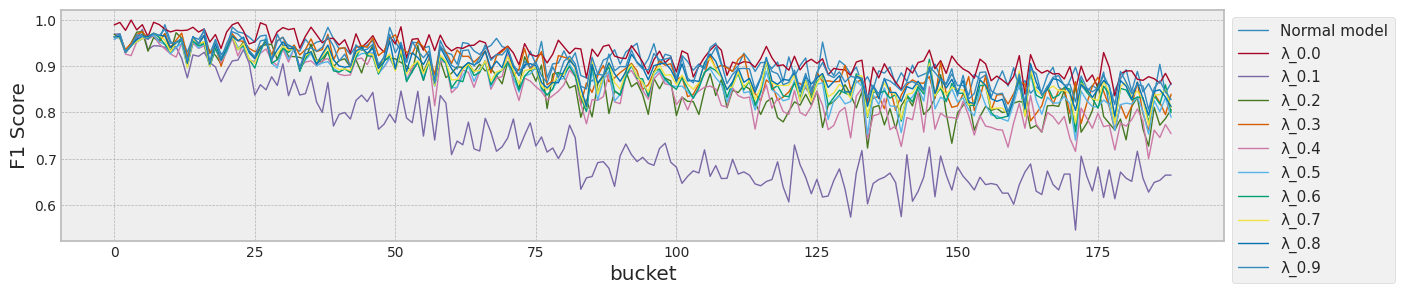

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #3, Normal model  0.948052  0.963351  0.910250  0.863388  0.000000
1                     0.0  0.986667  0.989583  0.924242  0.861244  0.000558
2                     0.1  0.935897  0.969388  0.735043  0.664430  0.000000
3                     0.2  0.948052  0.969388  0.859339  0.805970  0.001725
4                     0.3  0.942675  0.964103  0.888039  0.839378  0.022187
5                     0.4  0.919255  0.958333  0.846983  0.754098  0.000000
6                     0.5  0.942675  0.958333  0.867006  0.789700  0.000000
7                     0.6  0.942675  0.963731  0.874524  0.800000  0.000000
8                     0.7  0.936709  0.963731  0.880149  0.810811  0.000000
9                     0.8  0.948718  0.963731  0.888645  0.812785  0.000000
10                    0.9  0.954839  0.963351  0.899143  0.827907  0.000000
max_mean_lambda= 0.0


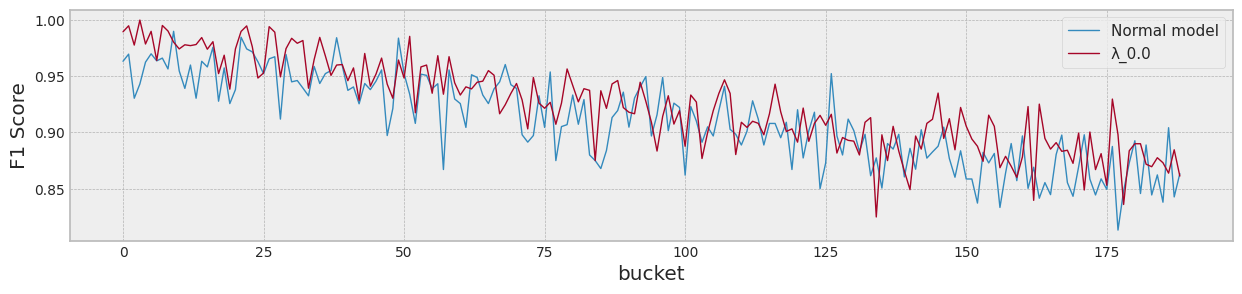

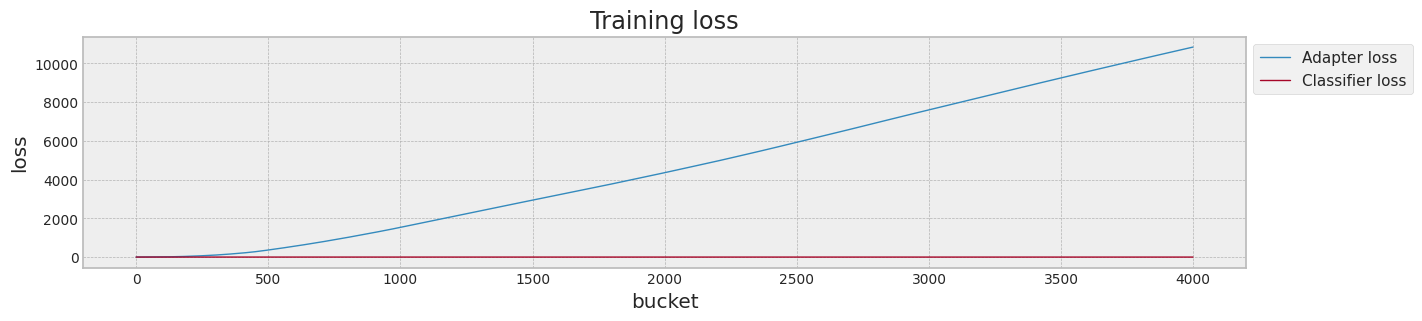

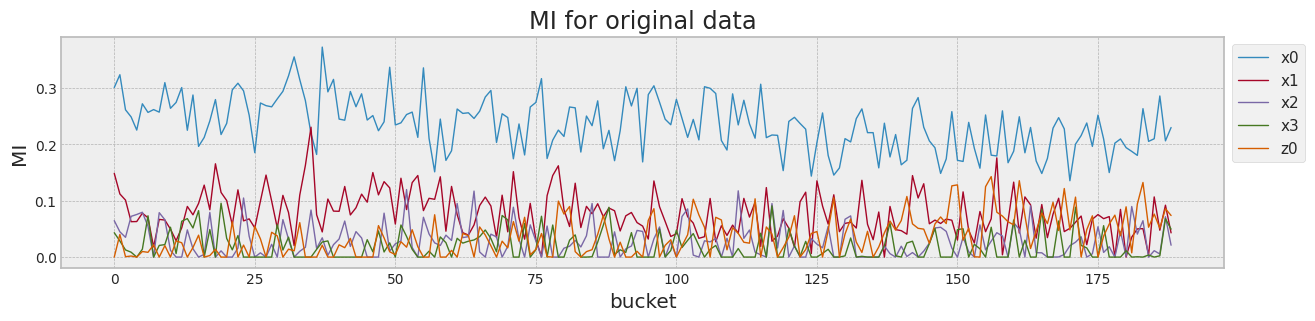

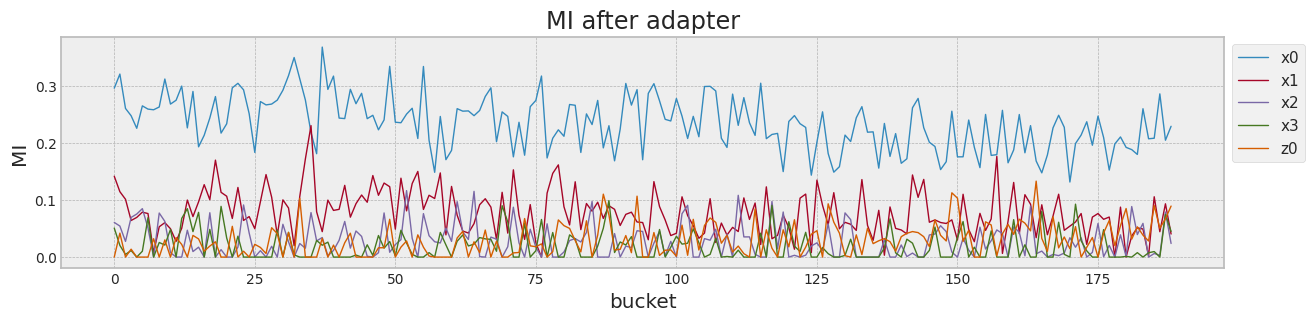

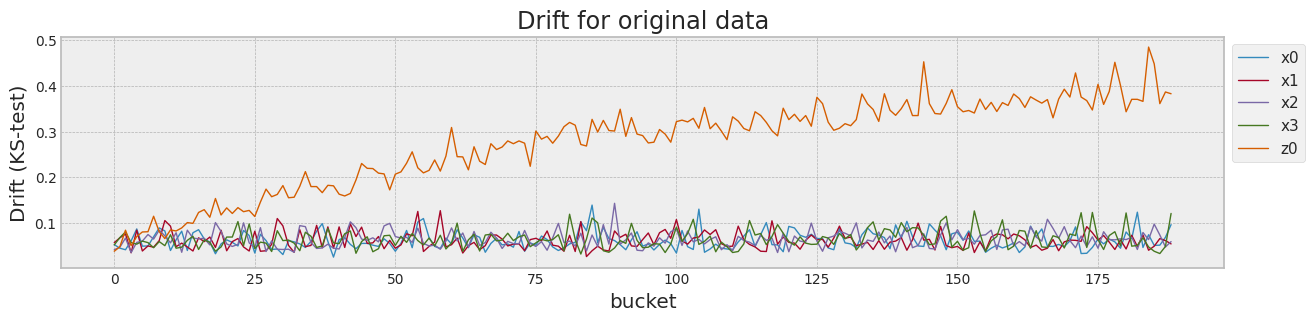

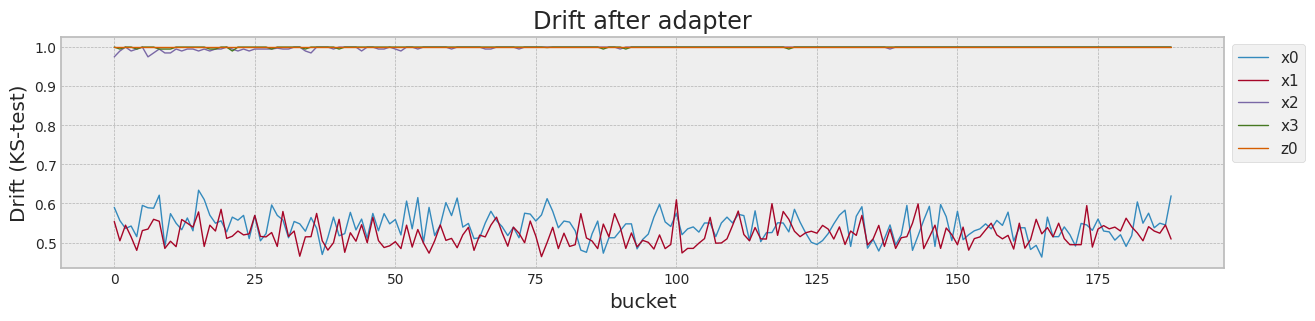

In [23]:

avaible_range = 40000

train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091]
lambda_f_set2 = [1.2]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X2[0:1800][['x0','x1','x2','x3','z0']],X2[2000:][['x0','x1','x2','x3','z0','b']],y2[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #3, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)


    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)


    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

#### I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(y^,z) 을 최소화 한다.

In [24]:
H=40
minibatch = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

In [25]:

def test_model2(generator_, tX, ty, s1):
    generator_.eval()


    y_hat = generator_(tX)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)

    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [26]:

def test_all_data2(generator,train_x,XT,yT, ShowChart = False):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        MIS = {}
        DRF = {}
        for col in columns:
            MIS[col] = []
            DRF[col] = []

        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            tmp_y = yT[bk*bucket_size:bk*bucket_size+bucket_size]
            #xs = adapter1(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(tmp_x[:,0:5])
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(tmp_y,predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)

            cpu_xs = tmp_x.cpu().data.numpy()
            mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=['x0','x1','x2','x3','z0']), tmp_y, discrete_features="auto")
            ks = __ks_drift(train_x.values,cpu_xs)
            for ix,col in enumerate(columns):
                MIS[col].append(mi_scores[col])
                DRF[col].append(ks[:,0][ix])

        df_mis = pd.DataFrame(MIS)
        df_drf = pd.DataFrame(DRF)

        if ShowChart:
            plt.figure(figsize=main_figsize)
            plt.plot(f1s,linewidth=1)
            plt.ylabel('F1 Score')
            plt.xlabel(f'bucket ({bucket_size})')
            plt.show()

            df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
            plt.legend(loc=1,ncol=5)
            plt.show()

            df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({bucket_size})',fontsize=15)
            plt.legend(loc=1,ncol=5)
            plt.show()

        print(f'mean of drift:\n{df_drf.mean()}')

    print('Mean F1 for all data:',np.mean(f1s))
    return f1s, df_mis, df_drf

In [29]:

class Generator2(nn.Module):
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        output = self.model(input_data)
        return output


In [30]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha, ShowChart = False):

    seed_everything()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator2().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train[:,0:5]).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss.cpu().data.numpy())

        if lambda_f >= 0.0:
            # -------------------------------
            #  MINE
            # -------------------------------
            s = np.random.choice(XS_train.shape[0],minibatch)
            x_sample = s1_train[s].reshape(-1,1) #torch.clone(s1_train[s].reshape(-1,1)) #Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
            y_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
            y_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)

            y2_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
            y2_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)


            ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
            ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

            # ret2(y의 샘플)는 maximize 하야 하고
            # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!!
            mi_loss = - ret1 + torch.abs(ret2)

            mi_losses.append(-ret2.cpu().data.numpy())
        else:
            mi_losses.append(0)

        optimizer_G.zero_grad()
        optimizer_M.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * mi_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model2(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'MINE loss':mi_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({bucket_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,df_loss

cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [mi loss: 0.000000] [G loss: 0.771558]
[Lambda: -0.100000] [Epoch 200/4000] [mi loss: 0.000000] [G loss: 0.753638]
[Lambda: -0.100000] [Epoch 400/4000] [mi loss: 0.000000] [G loss: 0.736817]
[Lambda: -0.100000] [Epoch 600/4000] [mi loss: 0.000000] [G loss: 0.720945]
[Lambda: -0.100000] [Epoch 800/4000] [mi loss: 0.000000] [G loss: 0.705910]
[Lambda: -0.100000] [Epoch 1000/4000] [mi loss: 0.000000] [G loss: 0.691624]
[Lambda: -0.100000] [Epoch 1200/4000] [mi loss: 0.000000] [G loss: 0.678010]
[Lambda: -0.100000] [Epoch 1400/4000] [mi loss: 0.000000] [G loss: 0.665005]
[Lambda: -0.100000] [Epoch 1600/4000] [mi loss: 0.000000] [G loss: 0.652554]
[Lambda: -0.100000] [Epoch 1800/4000] [mi loss: 0.000000] [G loss: 0.640607]
[Lambda: -0.100000] [Epoch 2000/4000] [mi loss: 0.000000] [G loss: 0.629125]
[Lambda: -0.100000] [Epoch 2200/4000] [mi loss: 0.000000] [G loss: 0.618071]
[Lambda: -0.100000] [Epoch 2400/4000] [mi loss: 0.000000] [G loss: 0.607418]

100%|██████████| 189/189 [00:02<00:00, 65.54it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6990493290579298
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 0.000816] [G loss: 0.753638]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 0.000844] [G loss: 0.736817]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 0.000601] [G loss: 0.720945]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 0.000434] [G loss: 0.705910]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 0.000769] [G loss: 0.691624]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 0.000709] [G loss: 0.678010]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 0.000819] [G loss: 0.665005]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 0.000775] [G loss: 0.652554]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 0.000812] [G loss: 0.640607]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 0.000508] [G loss: 0.629125]
[Lambda: 0.000000]

100%|██████████| 189/189 [00:02<00:00, 63.86it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6990493290579298
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.000085] [G loss: 0.753638]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.000104] [G loss: 0.736816]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: -0.000219] [G loss: 0.720945]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: -0.000258] [G loss: 0.705911]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.000102] [G loss: 0.691626]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.000138] [G loss: 0.678014]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: -0.000119] [G loss: 0.665010]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: -0.000058] [G loss: 0.652559]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.000090] [G loss: 0.640613]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: -0.000164] [G loss: 0.629131]
[Lambda: 0.10

100%|██████████| 189/189 [00:02<00:00, 65.53it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6990335995736013
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.000073] [G loss: 0.753638]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.000108] [G loss: 0.736815]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: -0.000210] [G loss: 0.720946]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: -0.000211] [G loss: 0.705912]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.000164] [G loss: 0.691629]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.000218] [G loss: 0.678018]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: -0.000121] [G loss: 0.665016]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: -0.000041] [G loss: 0.652566]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.000107] [G loss: 0.640622]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: -0.000244] [G loss: 0.629142]
[Lambda: 0.20

100%|██████████| 189/189 [00:02<00:00, 64.64it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6990600697782431
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.000084] [G loss: 0.753637]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.000145] [G loss: 0.736814]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: -0.000252] [G loss: 0.720947]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: -0.000235] [G loss: 0.705914]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.000139] [G loss: 0.691633]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.000249] [G loss: 0.678024]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: -0.000100] [G loss: 0.665024]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: -0.000071] [G loss: 0.652576]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.000078] [G loss: 0.640634]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: -0.000162] [G loss: 0.629153]
[Lambda: 0.30

100%|██████████| 189/189 [00:02<00:00, 65.08it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6990600697782431
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.000081] [G loss: 0.753637]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.000045] [G loss: 0.736814]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: -0.000232] [G loss: 0.720948]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: -0.000220] [G loss: 0.705917]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.000128] [G loss: 0.691638]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.000234] [G loss: 0.678033]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: -0.000100] [G loss: 0.665035]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.000000] [G loss: 0.652590]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.000104] [G loss: 0.640651]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: -0.000228] [G loss: 0.629173]
[Lambda: 0.400

100%|██████████| 189/189 [00:02<00:00, 65.85it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6992101918516533
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.000082] [G loss: 0.753636]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.000148] [G loss: 0.736812]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: -0.000230] [G loss: 0.720951]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: -0.000203] [G loss: 0.705921]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.000158] [G loss: 0.691648]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.000169] [G loss: 0.678047]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: -0.000119] [G loss: 0.665052]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: -0.000020] [G loss: 0.652609]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.000085] [G loss: 0.640674]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: -0.000257] [G loss: 0.629200]
[Lambda: 0.50

100%|██████████| 189/189 [00:02<00:00, 66.25it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6994443667909988
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.000083] [G loss: 0.753635]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000143] [G loss: 0.736810]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: -0.000188] [G loss: 0.720954]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: -0.000236] [G loss: 0.705928]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.000160] [G loss: 0.691661]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.000188] [G loss: 0.678066]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: -0.000129] [G loss: 0.665078]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: -0.000074] [G loss: 0.652639]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.000087] [G loss: 0.640714]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: -0.000231] [G loss: 0.629243]
[Lambda: 0.60

100%|██████████| 189/189 [00:02<00:00, 66.49it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6995009778052043
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.000082] [G loss: 0.753633]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000147] [G loss: 0.736808]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: -0.000196] [G loss: 0.720961]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: -0.000220] [G loss: 0.705943]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.000151] [G loss: 0.691693]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.000229] [G loss: 0.678113]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: -0.000120] [G loss: 0.665132]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: -0.000105] [G loss: 0.652705]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.000086] [G loss: 0.640785]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: -0.000170] [G loss: 0.629321]
[Lambda: 0.70

100%|██████████| 189/189 [00:03<00:00, 62.31it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.6996696132260972
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.000079] [G loss: 0.753632]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000144] [G loss: 0.736809]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: -0.000204] [G loss: 0.720991]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: -0.000204] [G loss: 0.705985]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000119] [G loss: 0.691761]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000211] [G loss: 0.678214]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: -0.000121] [G loss: 0.665256]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: -0.000097] [G loss: 0.652845]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000084] [G loss: 0.640956]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: -0.000259] [G loss: 0.629507]
[Lambda: 0.80

100%|██████████| 189/189 [00:02<00:00, 65.64it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.7003750367111018
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 0.000838] [G loss: 0.771558]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.000080] [G loss: 0.753640]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000065] [G loss: 0.736829]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: -0.000211] [G loss: 0.721102]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: -0.000215] [G loss: 0.706171]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000192] [G loss: 0.692061]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000207] [G loss: 0.678622]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: -0.000134] [G loss: 0.665756]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: -0.000070] [G loss: 0.653436]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000088] [G loss: 0.641625]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: -0.000247] [G loss: 0.630247]
[Lambda: 0.90

100%|██████████| 189/189 [00:02<00:00, 66.33it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.064253
x3    0.064427
z0    0.274292
dtype: float64
Mean F1 for all data: 0.7044816277789685


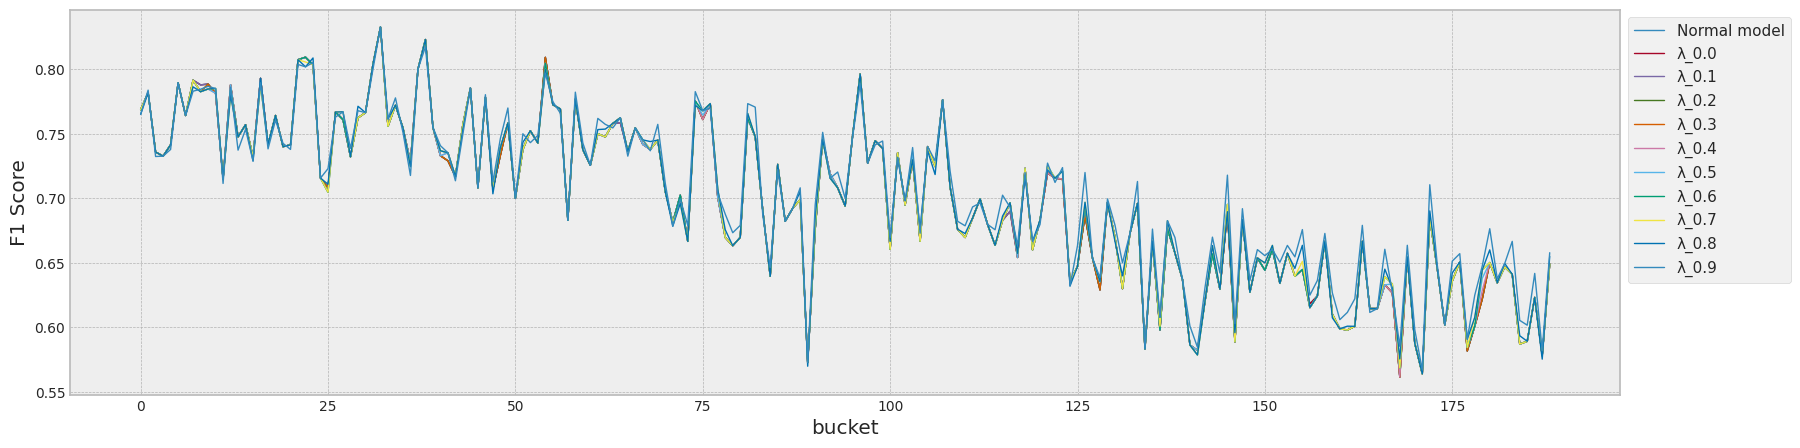

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #3, Normal model  0.719101  0.768519  0.699049  0.649123         0
1                     0.0  0.719101  0.768519  0.699049  0.649123         0
2                     0.1  0.719101  0.768519  0.699034  0.649123         0
3                     0.2  0.719101  0.768519  0.699060  0.649123         0
4                     0.3  0.719101  0.768519  0.699060  0.649123         0
5                     0.4  0.719101  0.768519  0.699210  0.649123         0
6                     0.5  0.719101  0.768519  0.699444  0.649123         0
7                     0.6  0.719101  0.768519  0.699501  0.649123         0
8                     0.7  0.719101  0.768519  0.699670  0.649123         0
9                     0.8  0.719101  0.764977  0.700375  0.655022         0
10                    0.9  0.719101  0.764977  0.704482  0.657895         0
max_mean_lambda= 0.9


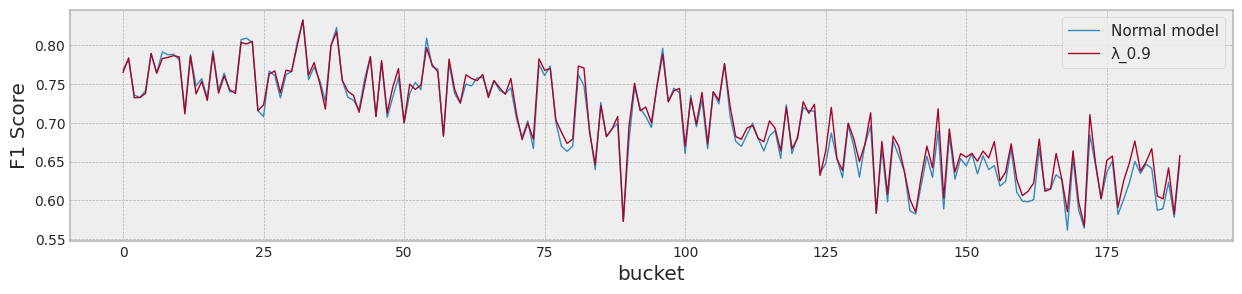

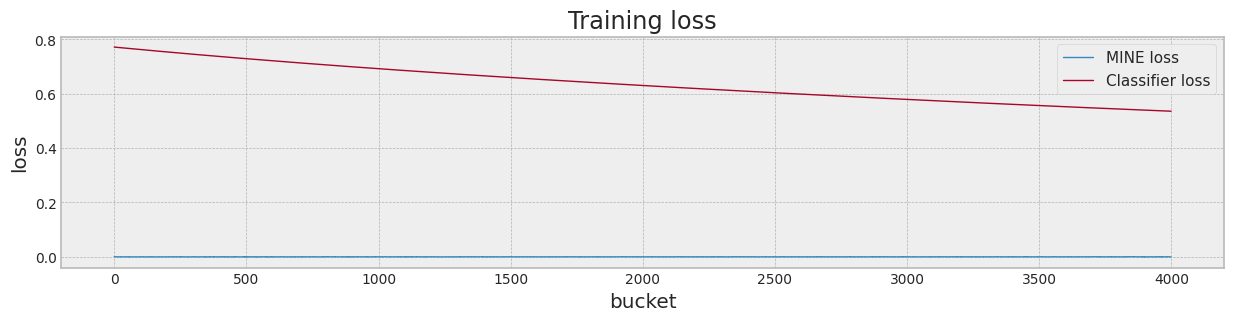

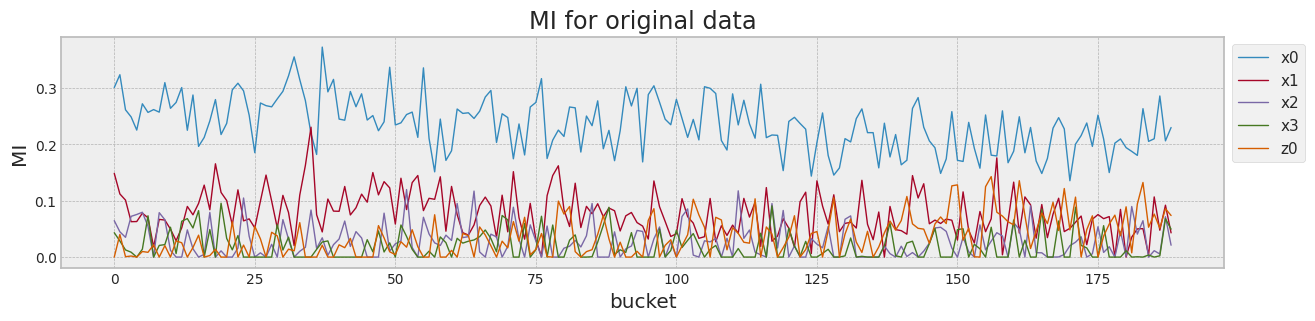

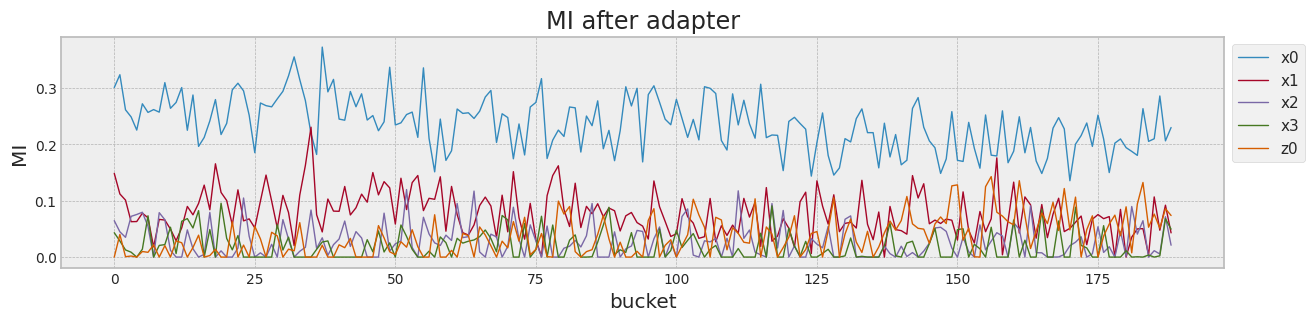

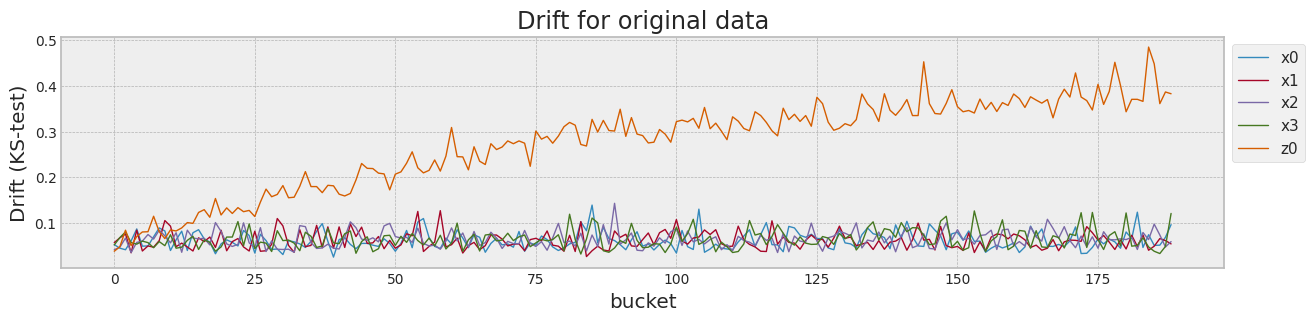

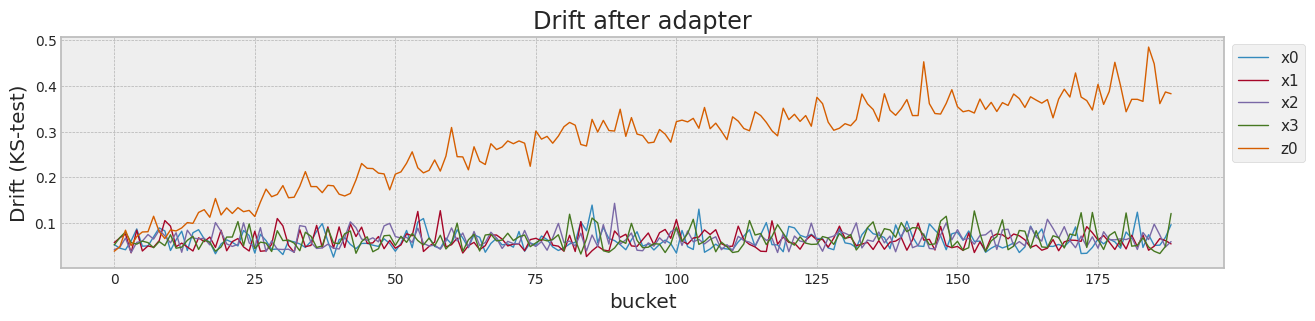

In [31]:
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

#lambda_f_set = [0.5] #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [-0.1, 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]
infos = {}
for lambda_f in lambda_f_set:

    f1,mi,last_generator, df_loss = train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.0)
    tad,df_mis,df_drf =  test_all_data2(last_generator,X2[0:1800][['x0','x1','x2','x3','z0']],X2[2000:][['x0','x1','x2','x3','z0']], y2[2000:])

    if lambda_f < 0.0:
        result_table2['lambda'].append("Case #3, Normal model")
        result_table['Normal model'] = tad
    else:
        result_table2['lambda'].append(lambda_f)
        result_table[f'λ_{lambda_f}'] = tad

    infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(tad[0])
    result_table2['mean_f1'].append(np.mean(tad))
    result_table2['last_f1'].append(tad[-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(20,5),linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

result4_df = pd.DataFrame(result_table2)

print(result4_df)

max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

print('max_mean_lambda=',max_mean_lambda.values[0])

result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

og_loss,og_mis,og_drf = infos['λ_-0.1']
df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
result4_df[['test_f1','init_f1','mean_f1','last_f1','MI(y^,z)']].plot.bar(figsize=main_figsize,rot=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

#### b를 대입하여 b가 작을때는 I(y^,z)을 최대화, b가 커질수록I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(G(x,b=0),z) 을 최대화, I(G(x,b=1),z) 을 최소화 한다.

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha, ShowChart = False):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        else:
            xs = XS_train[:,0:5]
            a_loss = torch.tensor(0)

        a_losses.append(a_loss.cpu().data.numpy())
        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss.cpu().data.numpy())

        # -------------------------------
        #  MINE
        # -------------------------------
        if lambda_f >= 0.0:
            #Sample을 앞 뒤 반으로 나눈다.
            sa = np.random.choice(range(0,int(XS_train.shape[0]/2)),minibatch)
            sb = np.random.choice(range(int(XS_train.shape[0]/2),XS_train.shape[0]),minibatch)

            # z0에 대해서...
            x_sample = xs[sa,4].reshape(-1,1)
            y_sample = gen_y[sa] # y_train[s].reshape(-1,1) #gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
            y_shuffle = gen_y[np.random.permutation(sa)] #y_train[np.random.permutation(s)].reshape(-1,1) # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)

            x2_sample = xs[sb,4].reshape(-1,1)
            y2_sample = gen_y[sb]
            y2_shuffle = gen_y[np.random.permutation(sb)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)

            ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
            ret2 = torch.mean(mine(x2_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x2_sample, y2_shuffle))))

            # ret1(bucket 앞부분의 Sample에 대한 MI)는 maximize 하야 하고
            # ret2(bucket 뒷부분의 Sample에 대한 MI)는 0으로 minimize 해야 한다.!!! => 즉, bucket의 증가, 시간이 지난수록 MI를 낮추는 방향으로 학습을 진행 하는 것!
            mi_loss = - ret1 + torch.abs(ret2)
            mi_losses1.append(ret1.cpu().data.numpy())
            mi_losses2.append(ret2.cpu().data.numpy())
        else:
            mi_losses1.append(0)
            mi_losses2.append(0)

        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * (g_loss + a_loss) + lambda_f * mi_loss
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss1: %f] [mi loss2: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses1[-1], mi_losses2[-1], a_losses[-1], g_losses[-1])
                )

        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])
    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses,'MI1/2 loss':mi_losses1,'MI2/2 loss':mi_losses2})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({bucket_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=(20,5))
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='Classifier loss')
    plt.plot(mi_losses1,linewidth=1,label='MI1/2 loss')
    plt.plot(mi_losses2,linewidth=1,label='MI2/2 loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

In [ ]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [-0.1, 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.0] #[0.391]

for lambda_f2 in lambda_f_set2:

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter,df_loss = train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        tad,df_mis,df_drf  = test_all_data(last_generator,last_adapter,X2[0:1800][['x0','x1','x2','x3','z0']], X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #3, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

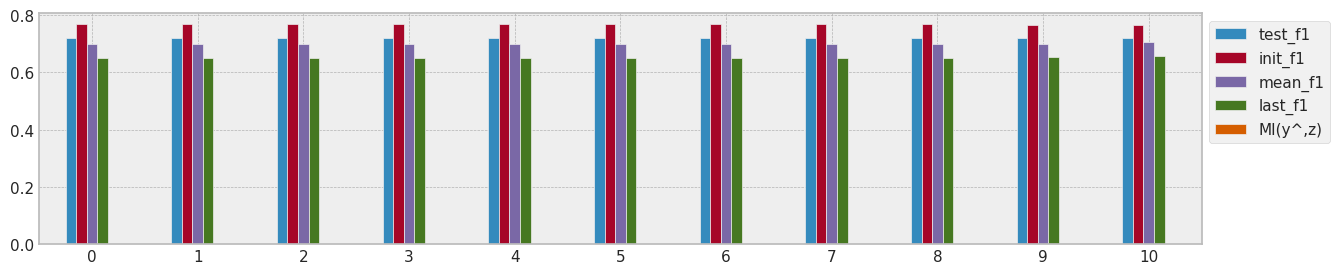

In [32]:
result4_df[['test_f1','init_f1','mean_f1','last_f1','MI(y^,z)']].plot.bar(figsize=main_figsize,rot=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

# Case #4 (Case #1,2,3의 상황이 각 feature에 혼재되어 있는 경우)

In [ ]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = np.random.normal(1,cor_,data_size)

y_array = []
cor_const = cor[4]
cor_const2 = 3/x.shape[0]
for ii in range(x.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 고정, Drift의 증가 - x3
    e1 = np.random.normal(0.0, cor_const2 * ii)
    x[ii,3] = x[ii,3] + e1
    y_array.append(np.sum(cor * x[ii])+e)

y = [1 if y_ > 5 else 0 for y_ in y1_array]

#Case #1 MI의 감소, Drift의 증가 - x2
for i in range(400):
    s = i*100
    x[s:s+100,2] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)

In [ ]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x0    0.227465
z0    0.088169
x2    0.024896
x1    0.018550
x3    0.000000
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:02<00:00, 64.67it/s]


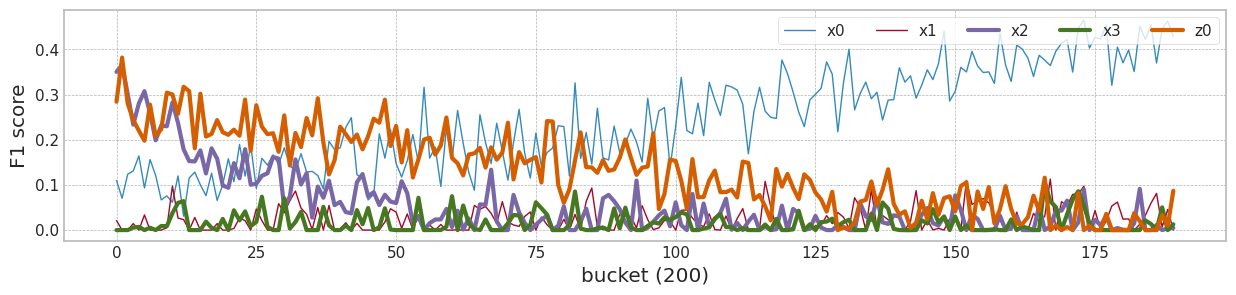

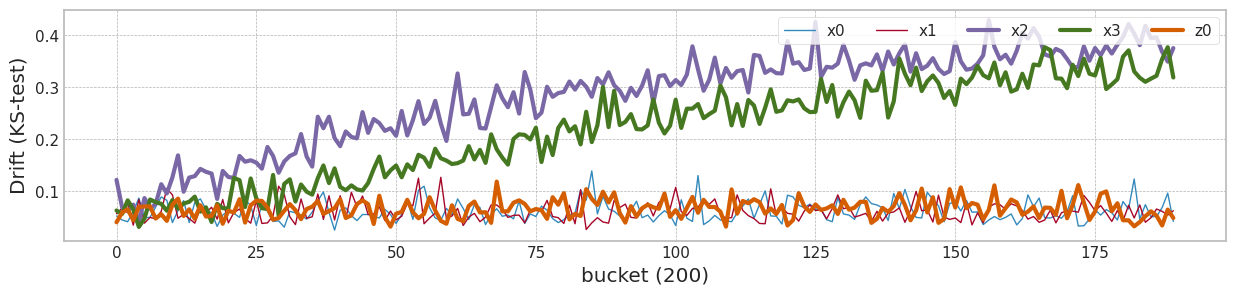

In [ ]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)
    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1']].values,linewidth=1,label=['x0','x1'])
    plt.plot(df_mis[['x2','x3','z0']].values,linewidth=3,label=['x2','x3','z0'])
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1']].values,linewidth=1,label=['x0','x1'])
    plt.plot(df_drf[['x2','x3','z0']].values,linewidth=3,label=['x2','x3','z0'])
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    #df_mis.plot(figsize=(20,5),linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

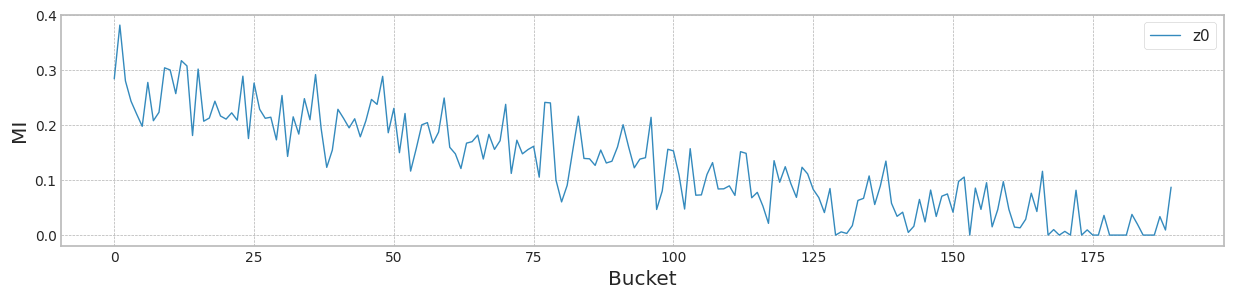

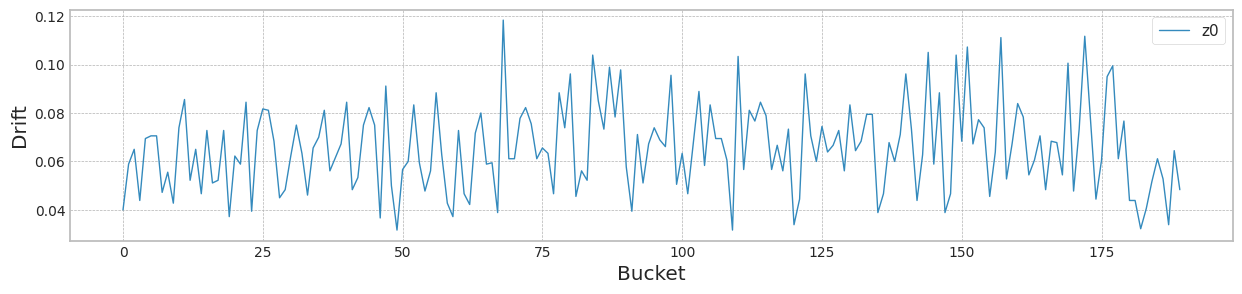

In [ ]:
# Case #2, MI의 증감(상대적), Drift의 고정 - z0
df_mis['z0'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['z0'].plot(figsize=main_figsize,linewidth=1,ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

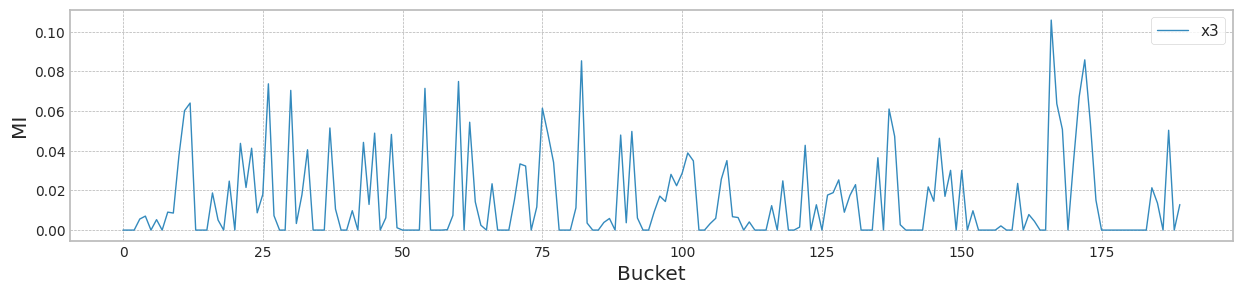

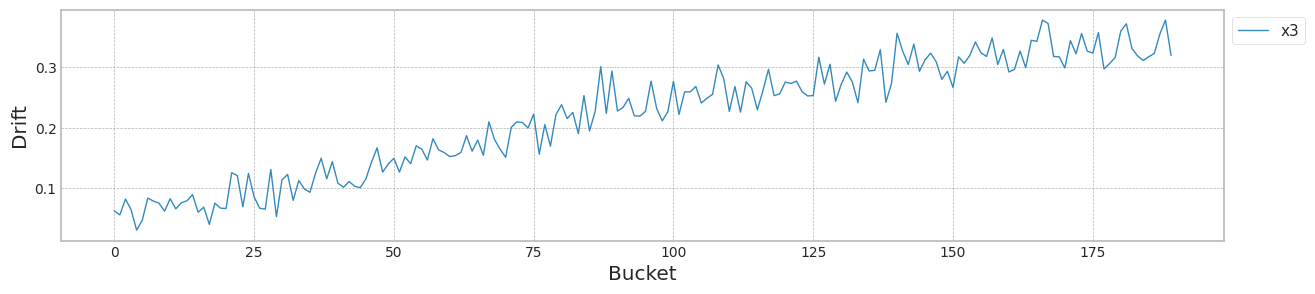

In [ ]:
# Case #3 MI의 고정, Drift의 증가 - x3
df_mis['x3'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['x3'].plot(figsize=main_figsize,linewidth=1,ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

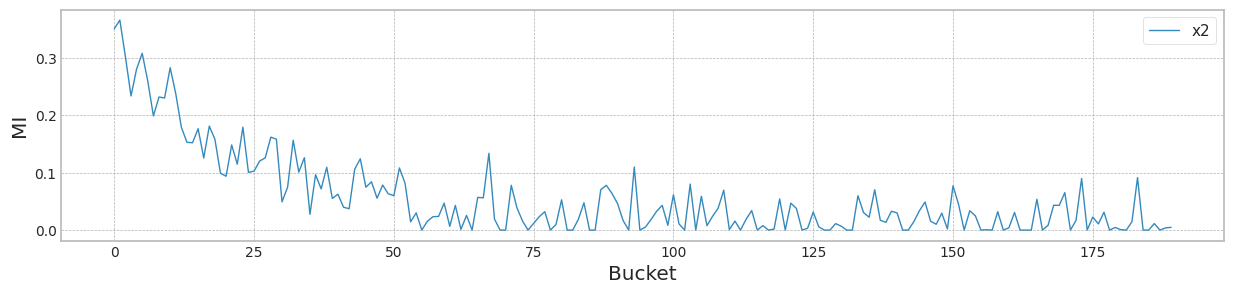

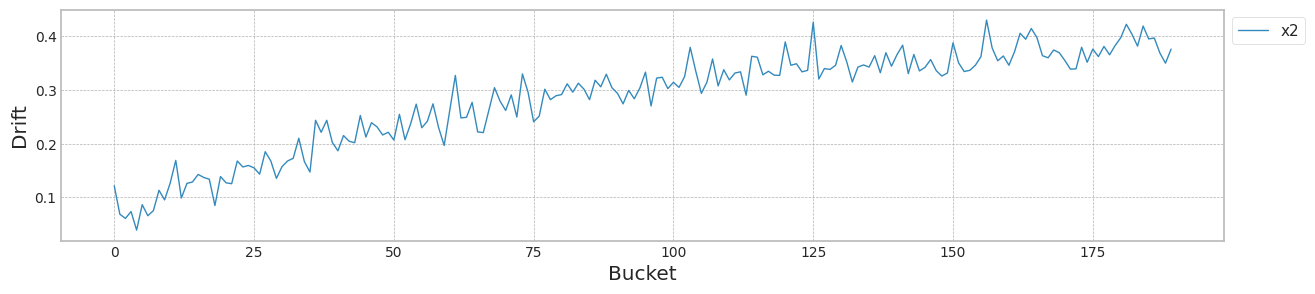

In [ ]:
#Case #1 MI의 감소, Drift의 증가 - x2
df_mis['x2'].plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
df_drf['x2'].plot(figsize=main_figsize,linewidth=1,ylabel='Drift',xlabel='Bucket',fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Case #4의 학습

cuda:0


100%|██████████| 1000/1000 [00:27<00:00, 36.34it/s]


MSE: 0.06
RMSE: 0.25


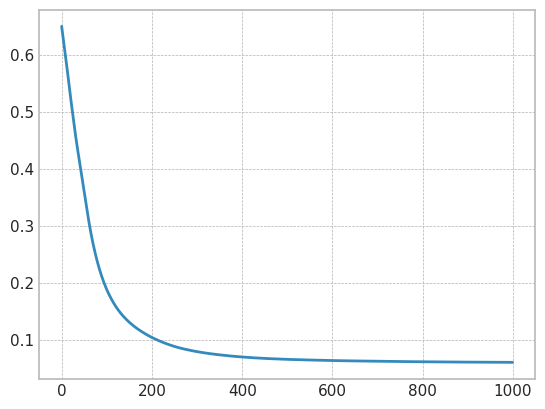

In [ ]:
import copy
import torch.optim as optim

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

In [ ]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.9732142857142857


100%|██████████| 189/189 [00:00<00:00, 448.41it/s]


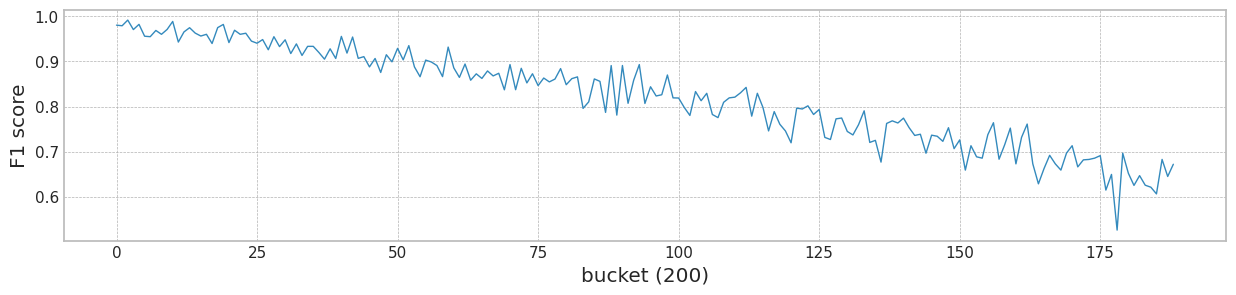

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #4 Feature 5  0.973214  0.980237  0.821443  0.672489  0.004783

In [ ]:
XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

result_table3['lambda'].append('Case #4 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['x2'])

pd.DataFrame(result_table3)

cuda:0


100%|██████████| 1000/1000 [00:27<00:00, 36.35it/s]


MSE: 0.08
RMSE: 0.28


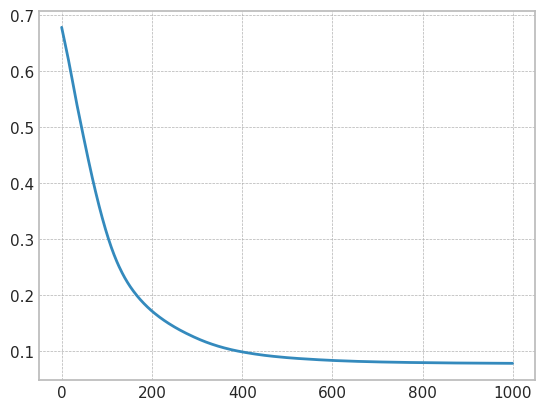

In [ ]:
import copy
import torch.optim as optim

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 4, test_f1',f1)

In [ ]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 4, test_f1',f1)

feature 4, test_f1 0.9652173913043478


100%|██████████| 189/189 [00:00<00:00, 460.32it/s]


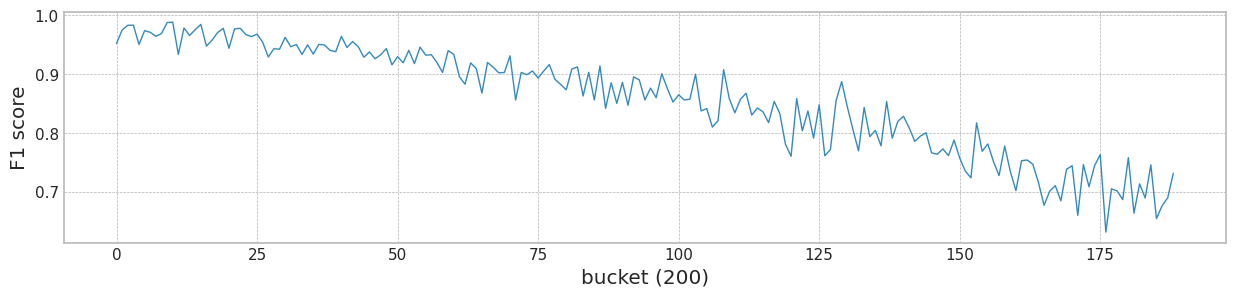

lambda   test_f1  init_f1   mean_f1   last_f1  MI(y^,z)
0  Case #4 Feature 5  0.965217    0.952  0.856297  0.731092  0.004783

In [ ]:
XT = X[2000:][['x0','x1','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({bucket_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

result_table3['lambda'].append('Case #4 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['x2'])

pd.DataFrame(result_table3)

## 내성학습의 적용!

In [ ]:
X['b'] = [int(b) for b in X.index.values]
X

x0        x1         x2        x3        z0      b
0      1.877314  1.185467   0.569114  1.124792 -1.925585      0
1      2.846794  0.461018   1.846127  1.282188  3.281450      1
2      2.232850  0.876278   0.988374  2.019024  0.187403      2
3     -0.198843  2.579531   2.045837  1.019120  2.385340      3
4      1.618080  1.683218   1.924591  0.696970  0.195648      4
...         ...       ...        ...       ...       ...    ...
39995 -0.321489  0.268097  -5.328180  1.865373  4.096949  39995
39996 -0.037401  1.055617  -3.625696  0.332384  3.850920  39996
39997  2.262545 -0.256564   4.910739  5.040302  0.498200  39997
39998  0.823467  1.489013   8.341265  1.477920  5.022454  39998
39999  2.024101  2.498025  11.309512  6.730665  0.816579  39999

[40000 rows x 6 columns]

In [ ]:

def train_model4(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha, ShowChart = False):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        else:
            xs = XS_train[:,0:5]
            a_loss = torch.tensor(0)

        a_losses.append(a_loss.cpu().data.numpy())

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss.cpu().data.numpy())

        # -------------------------------
        #  MINE
        # -------------------------------
        if lambda_f >= 0.0:
            #Sample을 앞 뒤 반으로 나눈다.
            sa = np.random.choice(range(0,int(XS_train.shape[0]/2)),minibatch)
            sb = np.random.choice(range(int(XS_train.shape[0]/2),XS_train.shape[0]),minibatch)

            # Case #3에 해당하는, MI변화 없이, Drift만 변하는 feature는 x3 이다.
            x_sample = xs[sa,2].reshape(-1,1) # Variable(torch.clone(XS_train[sa,2].detach().reshape(-1,1)) , requires_grad = True).to(device)
            y_sample = gen_y[sa] # y_train[s].reshape(-1,1) #gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
            y_shuffle = gen_y[np.random.permutation(sa)] #y_train[np.random.permutation(s)].reshape(-1,1) # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)

            x2_sample = xs[sb,2].reshape(-1,1) #Variable(torch.clone(XS_train[sb,2].detach().reshape(-1,1)) , requires_grad = True).to(device)
            y2_sample = gen_y[sb]
            y2_shuffle = gen_y[np.random.permutation(sb)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)

            ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
            ret2 = torch.mean(mine(x2_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x2_sample, y2_shuffle))))

            # ret1(bucket 앞부분의 Sample에 대한 MI)는 maximize 하야 하고
            # ret2(bucket 뒷부분의 Sample에 대한 MI)는 0으로 minimize 해야 한다.!!! => 즉, bucket의 증가, 시간이 지난수록 MI를 낮추는 방향으로 학습을 진행 하는 것!
            mi_loss = - ret1 + torch.abs(ret2)
            mi_losses1.append(-ret1.cpu().data.numpy())
            mi_losses2.append(-ret2.cpu().data.numpy())
        else:
            mi_losses1.append(0)
            mi_losses2.append(0)


        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * (g_loss + a_loss) + lambda_f * mi_loss
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss1: %f] [mi loss2: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses1[-1], mi_losses2[-1], a_losses[-1], g_losses[-1])
                )
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])
    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses,'MI1/2 loss':mi_losses1,'MI2/2 loss':mi_losses2})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({bucket_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=(20,5))
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='Classifier loss')
    plt.plot(mi_losses1,linewidth=1,label='MI1/2 loss')
    plt.plot(mi_losses2,linewidth=1,label='MI2/2 loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

lambda_f2 1.0
cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.656576]
[Lambda: -0.100000] [Epoch 200/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.588782]
[Lambda: -0.100000] [Epoch 400/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.510903]
[Lambda: -0.100000] [Epoch 600/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.434545]
[Lambda: -0.100000] [Epoch 800/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.360120]
[Lambda: -0.100000] [Epoch 1000/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.298358]
[Lambda: -0.100000] [Epoch 1200/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.250038]
[Lambda: -0.100000] [Epoch 1400/4000] [mi loss1: 0.000000] [mi loss2: 0.000000] [A loss: 0.000000] [G loss: 0.212929]
[Lambda: -0.100000] [Epoch 1600/4000] [mi 

100%|██████████| 189/189 [00:03<00:00, 53.05it/s]


mean of drift:
x0    0.061681
x1    0.060982
x2    0.281505
x3    0.217504
z0    0.065844
dtype: float64
Mean F1 for all data: 0.8242068388673565
cuda:0
[Lambda: 0.000000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss1: 0.018197] [mi loss2: 0.019380] [A loss: 0.006962] [G loss: 0.580296]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss1: 0.024314] [mi loss2: 0.024223] [A loss: 0.003029] [G loss: 0.497959]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss1: 0.024202] [mi loss2: 0.027695] [A loss: 0.003171] [G loss: 0.421087]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss1: 0.030584] [mi loss2: 0.031179] [A loss: 0.004157] [G loss: 0.343848]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss1: 0.036072] [mi loss2: 0.038640] [A loss: 0.004805] [G loss: 0.280328]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss1: 0.036753] [mi loss2: 0.036298] [A loss: 0.005174] [G loss: 0.231553]
[Lambda: 0.000000] [Epoch 1400/400

100%|██████████| 189/189 [00:03<00:00, 49.87it/s]


mean of drift:
x0    0.285388
x1    0.121746
x2    0.272801
x3    0.220829
z0    0.110347
dtype: float64
Mean F1 for all data: 0.8553831973884488
cuda:0
[Lambda: 0.100000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss1: -0.002342] [mi loss2: 0.000000] [A loss: 0.006957] [G loss: 0.580295]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss1: -0.008004] [mi loss2: -0.004831] [A loss: 0.003023] [G loss: 0.497913]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss1: -0.022482] [mi loss2: -0.022867] [A loss: 0.003157] [G loss: 0.420992]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss1: -0.092332] [mi loss2: -0.009585] [A loss: 0.004342] [G loss: 0.343493]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss1: -0.133467] [mi loss2: 0.084282] [A loss: 0.005431] [G loss: 0.279499]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss1: -0.182966] [mi loss2: -0.107021] [A loss: 0.005674] [G loss: 0.230805]
[Lambda: 0.100000] [Epoc

100%|██████████| 189/189 [00:03<00:00, 51.67it/s]


mean of drift:
x0    0.104195
x1    0.191029
x2    0.340664
x3    0.220608
z0    0.130676
dtype: float64
Mean F1 for all data: 0.804576903922468
cuda:0
[Lambda: 0.200000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss1: -0.005661] [mi loss2: -0.002976] [A loss: 0.006964] [G loss: 0.580287]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss1: -0.018919] [mi loss2: 0.000878] [A loss: 0.003135] [G loss: 0.497668]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss1: -0.058442] [mi loss2: -0.072787] [A loss: 0.003480] [G loss: 0.419989]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss1: -0.140112] [mi loss2: -0.014463] [A loss: 0.004751] [G loss: 0.341862]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss1: -0.172877] [mi loss2: 0.051152] [A loss: 0.005852] [G loss: 0.278213]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss1: -0.204838] [mi loss2: -0.134231] [A loss: 0.006347] [G loss: 0.229999]
[Lambda: 0.200000] [Epoch

100%|██████████| 189/189 [00:03<00:00, 55.55it/s]


mean of drift:
x0    0.252275
x1    0.293122
x2    0.428507
x3    0.225279
z0    0.154248
dtype: float64
Mean F1 for all data: 0.7891005060217278
cuda:0
[Lambda: 0.300000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss1: -0.003126] [mi loss2: -0.001026] [A loss: 0.006936] [G loss: 0.580307]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss1: -0.006383] [mi loss2: -0.001495] [A loss: 0.003067] [G loss: 0.497789]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss1: -0.026093] [mi loss2: -0.024917] [A loss: 0.003533] [G loss: 0.420401]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss1: -0.080277] [mi loss2: 0.004944] [A loss: 0.005128] [G loss: 0.342483]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss1: -0.139796] [mi loss2: -0.022175] [A loss: 0.007097] [G loss: 0.278133]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss1: -0.161872] [mi loss2: -0.084079] [A loss: 0.008008] [G loss: 0.230071]
[Lambda: 0.300000] [Epo

100%|██████████| 189/189 [00:03<00:00, 53.34it/s]


mean of drift:
x0    0.364156
x1    0.435597
x2    0.679212
x3    0.317046
z0    0.201076
dtype: float64
Mean F1 for all data: 0.7261842434003714
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss1: -0.002629] [mi loss2: -0.000801] [A loss: 0.006931] [G loss: 0.580312]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss1: -0.017996] [mi loss2: 0.003155] [A loss: 0.003298] [G loss: 0.497249]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss1: -0.052309] [mi loss2: -0.066319] [A loss: 0.004129] [G loss: 0.418383]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss1: -0.140573] [mi loss2: 0.037517] [A loss: 0.005889] [G loss: 0.339426]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss1: -0.182276] [mi loss2: 0.059900] [A loss: 0.007099] [G loss: 0.276145]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss1: -0.214125] [mi loss2: -0.144258] [A loss: 0.008290] [G loss: 0.229065]
[Lambda: 0.400000] [Epoch

100%|██████████| 189/189 [00:03<00:00, 51.74it/s]


mean of drift:
x0    0.401446
x1    0.507795
x2    0.541329
x3    0.362781
z0    0.218889
dtype: float64
Mean F1 for all data: 0.7680726727808694
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss1: -0.003200] [mi loss2: -0.000065] [A loss: 0.006943] [G loss: 0.580281]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss1: -0.019401] [mi loss2: 0.003189] [A loss: 0.003494] [G loss: 0.496864]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss1: -0.058428] [mi loss2: -0.072017] [A loss: 0.004276] [G loss: 0.417346]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss1: -0.137151] [mi loss2: 0.037616] [A loss: 0.006687] [G loss: 0.338438]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss1: -0.175333] [mi loss2: 0.069612] [A loss: 0.008762] [G loss: 0.275101]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss1: -0.212959] [mi loss2: -0.146047] [A loss: 0.009481] [G loss: 0.229506]
[Lambda: 0.500000] [Epoch

100%|██████████| 189/189 [00:03<00:00, 50.69it/s]


mean of drift:
x0    0.454703
x1    0.619600
x2    0.577607
x3    0.490132
z0    0.260573
dtype: float64
Mean F1 for all data: 0.7561319009727044
cuda:0
[Lambda: 0.600000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss1: -0.004231] [mi loss2: -0.002253] [A loss: 0.006936] [G loss: 0.580268]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss1: -0.013231] [mi loss2: 0.003742] [A loss: 0.003563] [G loss: 0.496900]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss1: -0.052325] [mi loss2: -0.063340] [A loss: 0.004764] [G loss: 0.416431]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss1: -0.137755] [mi loss2: -0.002192] [A loss: 0.007301] [G loss: 0.337136]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss1: -0.180116] [mi loss2: 0.061630] [A loss: 0.010819] [G loss: 0.273427]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss1: -0.212279] [mi loss2: -0.140970] [A loss: 0.011659] [G loss: 0.229186]
[Lambda: 0.600000] [Epoc

100%|██████████| 189/189 [00:04<00:00, 46.60it/s]


mean of drift:
x0    0.532837
x1    0.735741
x2    0.606875
x3    0.647790
z0    0.314509
dtype: float64
Mean F1 for all data: 0.7447450086696678
cuda:0
[Lambda: 0.700000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss1: -0.003365] [mi loss2: -0.000565] [A loss: 0.006926] [G loss: 0.580297]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss1: -0.015701] [mi loss2: 0.000829] [A loss: 0.003765] [G loss: 0.496311]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss1: -0.051969] [mi loss2: -0.065383] [A loss: 0.005727] [G loss: 0.415198]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss1: -0.142374] [mi loss2: -0.024258] [A loss: 0.009478] [G loss: 0.337269]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss1: -0.185922] [mi loss2: 0.015165] [A loss: 0.010875] [G loss: 0.277021]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss1: -0.213514] [mi loss2: -0.146905] [A loss: 0.014241] [G loss: 0.233306]
[Lambda: 0.700000] [Epoc

100%|██████████| 189/189 [00:03<00:00, 50.66it/s]


mean of drift:
x0    0.554782
x1    0.808183
x2    0.617731
x3    0.841232
z0    0.358833
dtype: float64
Mean F1 for all data: 0.7336121674772125
cuda:0
[Lambda: 0.800000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss1: -0.004087] [mi loss2: -0.001966] [A loss: 0.006907] [G loss: 0.580477]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss1: -0.009824] [mi loss2: -0.006574] [A loss: 0.003442] [G loss: 0.496849]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss1: -0.016537] [mi loss2: -0.014567] [A loss: 0.006464] [G loss: 0.418099]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss1: -0.102562] [mi loss2: 0.013524] [A loss: 0.013008] [G loss: 0.337076]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss1: -0.156477] [mi loss2: 0.058608] [A loss: 0.015524] [G loss: 0.270305]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss1: -0.196665] [mi loss2: -0.126602] [A loss: 0.018983] [G loss: 0.226629]
[Lambda: 0.800000] [Epoc

100%|██████████| 189/189 [00:03<00:00, 49.71it/s]


mean of drift:
x0    0.673207
x1    0.875532
x2    0.494215
x3    0.945032
z0    0.406987
dtype: float64
Mean F1 for all data: 0.7150078090538379
cuda:0
[Lambda: 0.900000] [Epoch 0/4000] [mi loss1: -0.000000] [mi loss2: 0.000023] [A loss: 4.505148] [G loss: 0.704347]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss1: -0.003486] [mi loss2: -0.000890] [A loss: 0.007059] [G loss: 0.581398]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss1: -0.003826] [mi loss2: 0.000760] [A loss: 0.003632] [G loss: 0.496134]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss1: -0.027000] [mi loss2: -0.023834] [A loss: 0.005802] [G loss: 0.424298]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss1: -0.070571] [mi loss2: -0.000970] [A loss: 0.015177] [G loss: 0.364211]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss1: -0.095397] [mi loss2: 0.047476] [A loss: 0.033045] [G loss: 0.315770]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss1: -0.158013] [mi loss2: -0.098280] [A loss: 0.045373] [G loss: 0.272509]
[Lambda: 0.900000] [Epoc

100%|██████████| 189/189 [00:03<00:00, 49.41it/s]


mean of drift:
x0    0.913789
x1    0.948277
x2    0.603233
x3    0.940517
z0    0.730079
dtype: float64
Mean F1 for all data: 0.673500298993321


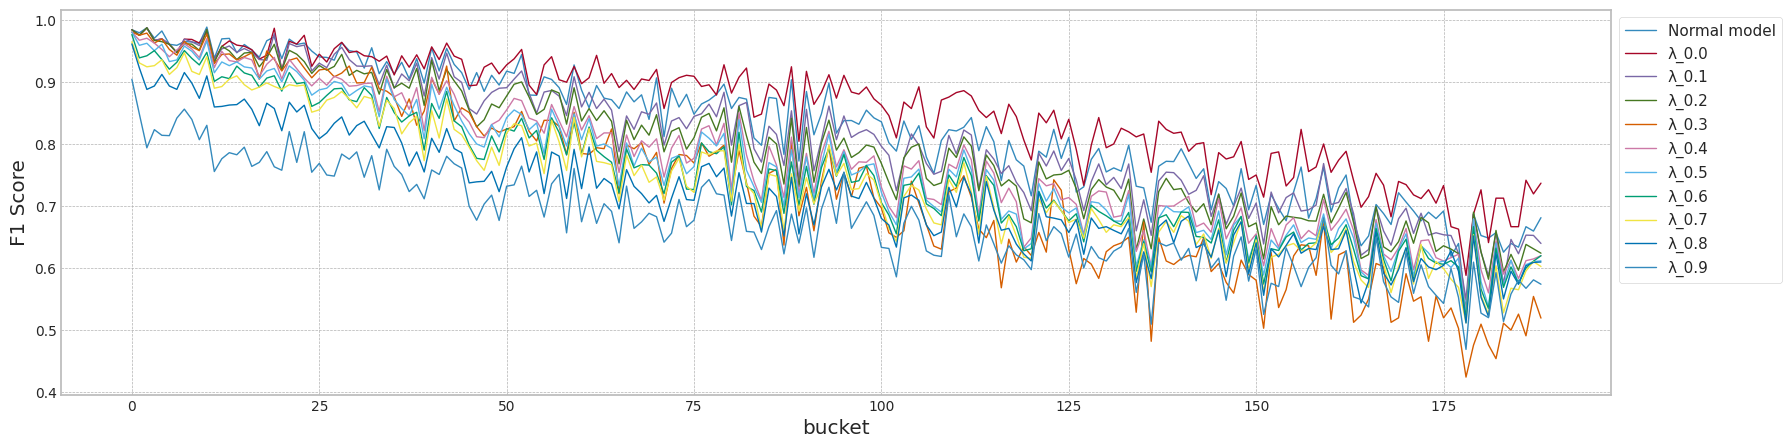

                   lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0   Case #4, Normal model  0.964912  0.984127  0.824207  0.681223  0.251604
1                     0.0  0.965517  0.984127  0.855383  0.736842  0.273702
2                     0.1  0.965517  0.984127  0.804577  0.639640  0.273702
3                     0.2  0.965517  0.984127  0.789101  0.623932  0.273702
4                     0.3  0.956897  0.980237  0.726184  0.519337  0.250918
5                     0.4  0.961373  0.980237  0.768073  0.619835  0.265421
6                     0.5  0.944206  0.980237  0.756132  0.611570  0.242659
7                     0.6  0.939655  0.976378  0.744745  0.619835  0.240245
8                     0.7  0.931034  0.964706  0.733612  0.602510  0.216298
9                     0.8  0.913793  0.961240  0.715008  0.609756  0.173093
10                    0.9  0.865546  0.904215  0.673500  0.573913  0.094125
max_mean_lambda= 0.0


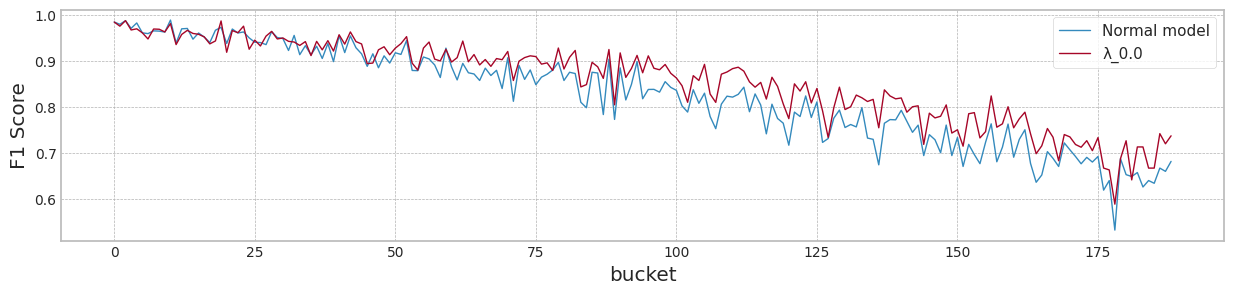

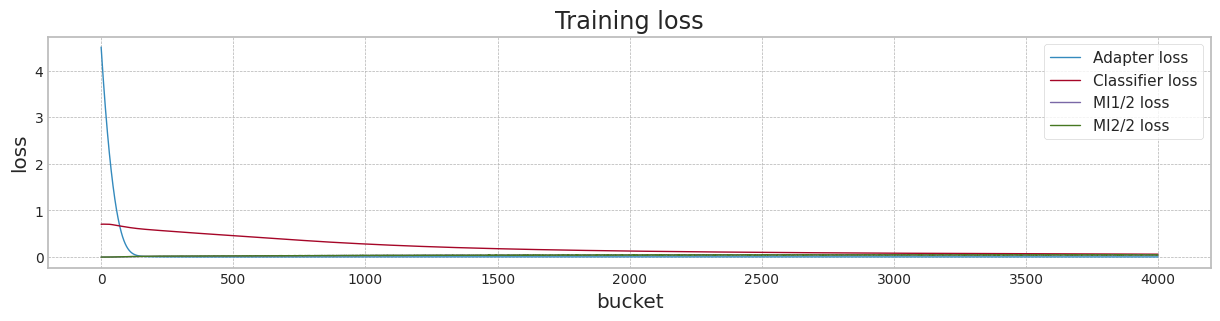

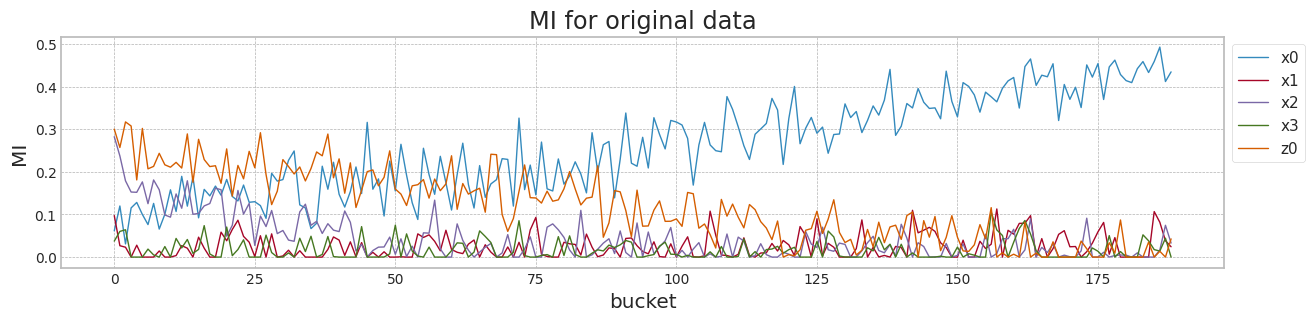

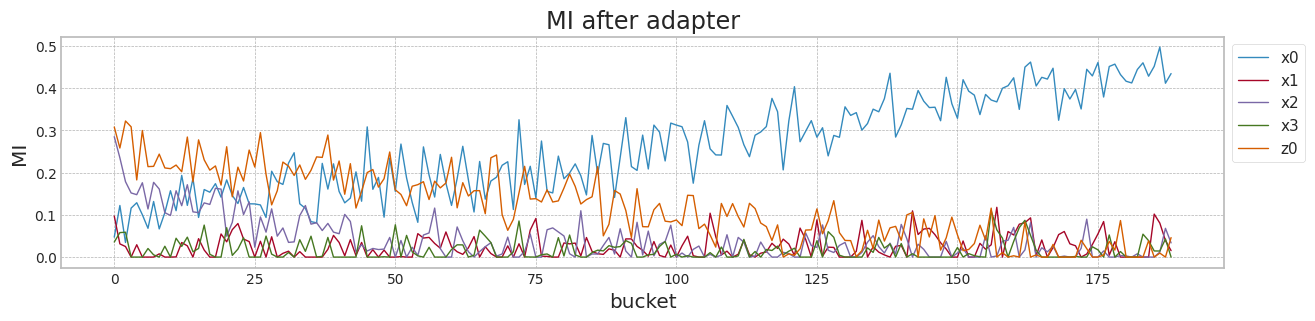

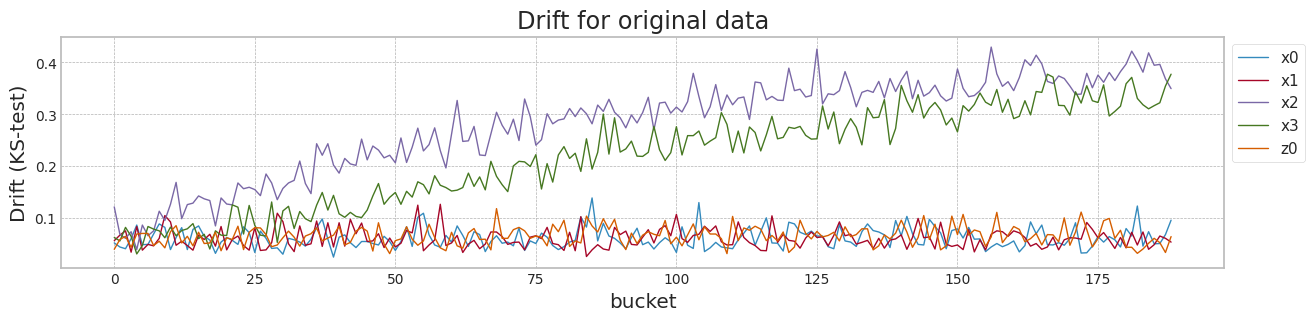

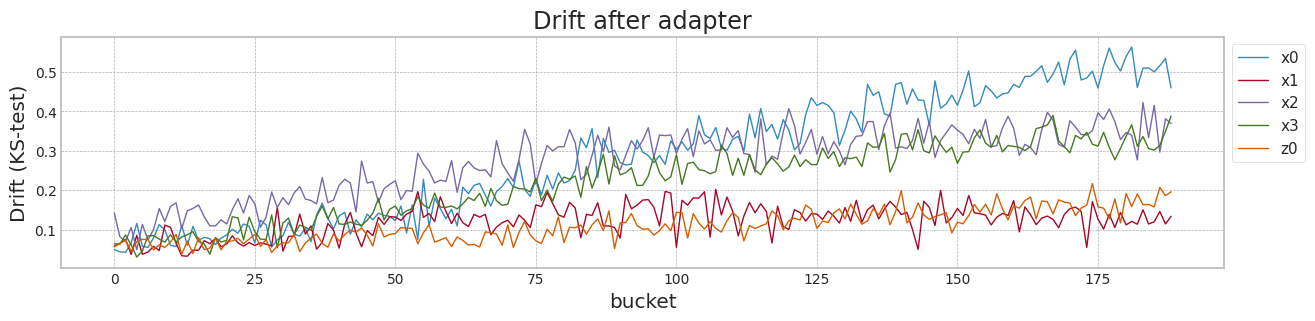

In [ ]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.0] # [0.07] #[0.391]

for lambda_f2 in lambda_f_set2:

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]
    infos = {}
    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter, df_loss = train_model4(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        tad,df_mis,df_drf  = test_all_data(last_generator,last_adapter,X[0:1800][['x0','x1','x2','x3','z0']], X[2000:][['x0','x1','x2','x3','z0','b']], y[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #4, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(20,5),linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

In [ ]:
#train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.2] #[0.391]

for lambda_f2 in lambda_f_set2:

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        tad = test_all_data(last_generator,last_adapter,X[0:1800][['x0','x1','x2','x3','z0']], X[2000:][['x0','x1','x2','x3','z0','b']], y[2000:])

        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #4, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(20,5),linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=(20,5),linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

lambda_f2 1.2
cuda:0
[Lambda: -0.100000] [Epoch 0/4000] [a loss: 0.000000] [G loss: 0.656576]
[Lambda: -0.100000] [Epoch 200/4000] [a loss: 0.000000] [G loss: 0.588782]
[Lambda: -0.100000] [Epoch 400/4000] [a loss: 0.000000] [G loss: 0.510903]
[Lambda: -0.100000] [Epoch 600/4000] [a loss: 0.000000] [G loss: 0.434545]
[Lambda: -0.100000] [Epoch 800/4000] [a loss: 0.000000] [G loss: 0.360120]
[Lambda: -0.100000] [Epoch 1000/4000] [a loss: 0.000000] [G loss: 0.298358]
[Lambda: -0.100000] [Epoch 1200/4000] [a loss: 0.000000] [G loss: 0.250038]
[Lambda: -0.100000] [Epoch 1400/4000] [a loss: 0.000000] [G loss: 0.212929]
[Lambda: -0.100000] [Epoch 1600/4000] [a loss: 0.000000] [G loss: 0.184483]
[Lambda: -0.100000] [Epoch 1800/4000] [a loss: 0.000000] [G loss: 0.162503]
[Lambda: -0.100000] [Epoch 2000/4000] [a loss: 0.000000] [G loss: 0.145254]
[Lambda: -0.100000] [Epoch 2200/4000] [a loss: 0.000000] [G loss: 0.131373]
[Lambda: -0.100000] [Epoch 2400/4000] [a loss: 0.000000] [G loss: 0.119885

ValueError: ignored

# real-world data(Loan data)의 실험

In [ ]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

## Data load

In [ ]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

## Data 정제

In [ ]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

In [ ]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

## Dataset 만들기

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:

X[2010].shape

In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

## Data의 MI, Drift 특성 파악
+ MI Top 5에 대하여 MI의 변화
+ MI Top 5에 대하여 Drift의 변화

In [ ]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

In [ ]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

In [ ]:
list(COLUMNS) not in top_columns_index

In [ ]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2_df = pd.DataFrame(X2,columns = COLUMNS)
X2_df_t5 = X2_df[top_columns]

In [ ]:
from tqdm import tqdm

bucket_size_array=[5000]#[10,50,100,200]
tl = X[2010].shape[0]

for bucket_size in bucket_size_array:

    MIS = {}
    DRF = {}
    for col in top_columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((X2.shape[0]-2000)/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2_df_t5[bk*bucket_size:bk*bucket_size+bucket_size],
                                   Y2[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X_df[top_columns].values,X2_df_t5[bk*bucket_size+tl:bk*bucket_size+bucket_size+tl].values)
        for ix,col in enumerate(top_columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Loan data의 학습

In [ ]:
import copy
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

tl,fl = X[2010].shape

loan_scaler = MinMaxScaler()
LX = loan_scaler.fit_transform(X[2010][:,top_columns_index])

X_train = torch.tensor(LX[0:int(tl*0.9)], dtype=torch.float32).to(device)
y_train = torch.tensor(Y[2010][0:int(tl*0.9)], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(LX[int(tl*0.9):tl], dtype=torch.float32).to(device)
y_test = torch.tensor(Y[2010][int(tl*0.9):tl], dtype=torch.float32).reshape(-1, 1).to(device)

# Define the model
loan_model = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)


# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(loan_model.parameters(), lr=0.0001)

n_epochs = 100   # number of epochs to run
batch_size = 1000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = -np.inf   # init to infinity
best_weights = None
history = []

for epoch in tqdm(range(n_epochs)):
    loan_model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = loan_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    loan_model.eval()
    y_pred = loan_model(X_test)
    y_pred = (y_pred.cpu().data.numpy()> 0.5).astype(float)
    f1 = f1_score(y_pred, y_test.cpu().data.numpy())
    f1 = float(f1)
    history.append(f1)
    if f1 > best_mse:
        best_mse = f1
        best_weights = copy.deepcopy(loan_model.state_dict())

# restore model and return best accuracy
loan_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
bucket_size_array=[3000]

for bucket_size in bucket_size_array:
    bucket_count = int(X2.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(loan_scaler.transform(X2[bk*bucket_size:bk*bucket_size+bucket_size][:,top_columns_index]), dtype=torch.float32).to(device)
        predicted_y = loan_model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y2[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.ylabel('F1 score')
    plt.xlabel('bucket')
    plt.title('Changes of F1 score according to bucket')
    plt.show()

result_table3['lambda'].append('Loan data, Feature 81')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(0.0)

pd.DataFrame(result_table3)

## Concept-drift tolerant model 적용.

+ 100개씩 한 bucket으로 만든다.

In [ ]:
df_accepted['b'] = (np.asarray(list(df_accepted.index))/100).astype(int)

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

In [ ]:
# bucket b의 확인!
X[2010][:,81]

In [ ]:
sum(X[2010][:,81]==57)

In [ ]:
X[2010][0,81] = 58
X[2010][1,81] = 58
X[2010][2,81] = 58

In [ ]:
sum(X[2010][:,81]==57)

In [ ]:
sum(X[2010][:,81]==58)

In [ ]:
sum(X[2010][:,81]==172)

In [ ]:
X[2010].shape

In [ ]:
X[2010][103:].shape

In [ ]:
X_df_t5 = pd.DataFrame(X[2010],columns=list(COLUMNS) + ['b'])[top_columns]

+ 학습셋 X[2010]에서, MI와 Drift의 변화

In [ ]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]
#bucket 58의 개수
tl = sum(X[2010][:,81]==58)

for bucket_size in bucket_size_array:

    MIS = {}
    DRF = {}
    for col in top_columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int(X[2010][tl:].shape[0]/bucket_size)
    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X_df_t5[bk*bucket_size:bk*bucket_size+bucket_size],
                                   Y[2010][bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X_df_t5[0:103].values,X_df_t5[bk*bucket_size+tl:bk*bucket_size+bucket_size+tl].values)
        for ix,col in enumerate(top_columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)
    df_mis.plot(figsize=(15,3),title='Mutual Information changes according to bucket',ylabel='MI',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    df_drf.plot(figsize=(15,3),title='Drift changes according to bucket',ylabel='Drift',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

+ 상태를 보니.... 좋은 결과가 안나올 듯... 싶은데...

### Concept-drift tolerant model 적용

<pre>
x0 --------------------------------------> |                        |
x1 --------------------------------------> |                        |
x2 --------------------------------------> |                        |
x3 --------------------------------------> |                        |
x4 --------------------------------------> | Discriminator (D(x,g)) |
                    ...                    | predictive model       | -> y^
xi+1----->|                     |- x'i+1-> |                        |
xi+2----->|  Generator G(xi,b)  |- x'i+2-> |                        |
xi+3----->|  (Adaptive model)   |- x'i+3-> |                        |
xi+4----->|                     |- x'i+4-> |                        |
xi+5----->|                     |- z'i+5-> |                        |
                     ^
                     |
                     b
</pre>

+ 위와 같이, MI Top5의 feature에 대하여 G를 적용하고, 나머지 feature는 그대로 Classification model에 들어가게 한다.

In [ ]:
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
#X2 = np.concatenate((X[2011],X[2012],X[2013]))
#Y2 = np.concatenate((Y[2011],Y[2012],Y[2013]))
max_b = np.max(X2[:,81])
max_b

In [ ]:

def train_model5(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]

    mi_losses1 = []
    mi_losses2 = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    fl = 81
    generator = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    ).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net().to(device)
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 500

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        # MI 높은 top 5의 column에 대해서 b에 대한 전처리 처리를 한다.
        if lambda_f > 0.0:
            xs = adapter(XS_train[:,top_columns_index],XS_train[:,81].reshape(-1,1)/max_b) # z0, b
            a_loss = torch.sum(mse_loss(xs, XS_train[:,top_columns_index]))
        else:
            xs = XS_train[:,top_columns_index]
            a_loss = 0

        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f > 0.0:
            loss = (1-lambda_f) * g_loss + lambda_f * a_loss * alpha
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_A.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )


    generator.eval()

    if lambda_f > 0.0:
        adapter.eval()
        ax = adapter(XS_test[:,top_columns_index],XS_test[:,81].reshape(-1,1)/max_b)
        #XS_test[:,top_columns_index] = ax
    else:
        ax = XS_test[:,top_columns_index]
        adapter = None

    y_hat = generator(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',y_test.shape)
    print('y_hat',y_hat.shape)

    f1 = f1_score(y_test.cpu().data.numpy(),y_hat)

    mi = 0.0
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))

    return f1,mi,generator,adapter

In [ ]:

def test_all_loan_data(generator,adapter,XT,yT):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('XT.shape',XT.shape)
    bucket_size_array=[3000]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size], dtype=torch.float32).to(device)
            if adapter == None:
                xs = tmp_x[:,top_columns_index]
            else:
                xs = adapter(tmp_x[:,top_columns_index],tmp_x[:,81].reshape(-1,1)/max_b)
            #tmp_x[:,top_columns_index] = xs
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))
    return f1s

In [ ]:
# 2010의 마지막 bucket의 개수가 94개... 157

loan_scaler = MinMaxScaler()
LX = loan_scaler.fit_transform(X[2010][:,0:81])
LX = np.concatenate((LX,X[2010][:,81].reshape(-1,1)),axis=1)

train_tensors = Namespace(XS_train = torch.tensor(LX[0:LX.shape[0] - 94], dtype=torch.float32),
                          y_train = torch.tensor(Y[2010][0:LX.shape[0] - 94], dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(LX[LX.shape[0] - 94:LX.shape[0]], dtype=torch.float32),
                         y_test = torch.tensor(Y[2010][LX.shape[0] - 94:LX.shape[0]], dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=200, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

# -0.1 은 기준 모델의 학습을 위한것.
lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.

lambda_f_set2 = [1.0] #[0.391]

for lambda_f2 in lambda_f_set2:

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:

        f1,mi,last_generator, last_adapter = train_model5(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=lambda_f2)
        TX = np.concatenate((loan_scaler.transform(X2[:,0:81]),X2[:,81].reshape(-1,1)),axis=1)
        result_table[f'lambda_{lambda_f}'] = test_all_loan_data(last_generator,last_adapter, TX , Y2)

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3),title='Changes of F1 score according to bucket',ylabel='F1 Score',xlabel='Bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    result4_df = pd.DataFrame(result_table2)

pd.concat([pd.DataFrame(result_table3),result4_df])